#### Initailization

In [2]:
desc = {
    "mean_power_i": "the average of the internal power in the layout",
    "mean_power_s": "the average of the switching power in the layout",
    "mean_power_sca": "the average of the toggle rate scaled power in the layout",
    "mean_power_all": "the average of power_all = power_i + power_s + power_sca in the layout",
    "mean_power_t_6": "the average of the power at time step 6 in the layout",
    "mean_power_t_13": "the average of the power at time step 13 in the layout",
    "mean_power_t_19": "the average of the power at time step 19 in the layout",
}

In [3]:
feat_func_list = []

In [4]:
selected_indices = [0, 1, 2, 3, 10, 17, 23]

In [5]:
train_design = ["RISCY-a", "RISCY-b", "RISCY-FPU-a", "RISCY-FPU-b"]
test_design_a = ["zero-riscy-a"]
test_design_b = ["zero-riscy-b"]

In [ ]:
api_key = "<your_api_key>"

def encode_image(features):
    features_b64 = []
    for image in features:
        buff = BytesIO()
        image.save(buff, format="PNG")
        buff.seek(0)
        image_b64 = base64.b64encode(buff.read()).decode()
        features_b64.append(image_b64)
    return features_b64

headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

In [7]:
import models
device = "cuda:4"
opt = {'task': 'irdrop_mavi', 'save_path': 'work_dir/IR_drop/', 'pretrained': '/home/felixchaotw/CircuitNet/model/IR_drop.pth', 'max_iters': 200000, 'plot_roc': False, 'arg_file': None, 'cpu': False, 'dataroot': '../../training_set/DRC', 'ann_file_train': './files/train_N28.csv', 'ann_file_test': './files/test_N28.csv', 'dataset_type': 'DRCDataset', 'batch_size': 16, 'aug_pipeline': ['Flip'], 'model_type': 'RouteNet', 'in_channels': 1, 'out_channels': 4, 'lr': 0.0002, 'weight_decay': 0, 'loss_type': 'MSELoss', 'eval_metric': ['NRMS', 'SSIM', 'EMD'], 'ann_file': './files/test_N28.csv', 'test_mode': True}
model = models.__dict__["MAVI"](**opt)
model.init_weights(**opt)
model.to(device)

/home/felixchaotw/mllm-physical-design/IR_Drop/feat_extract/models/mavi.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight = torch.load(pretrained, map_location='c

MAVI(
  (inc): DoubleConv3d(
    (double_conv): Sequential(
      (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
      (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv3d(
        (double_conv): Sequential(
          (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(128, 128, kernel_size=(3, 3

In [54]:
import warnings
warnings.filterwarnings("ignore")

#### Preprocessing

In [8]:
import numpy as np
from PIL import Image
import requests, base64
import json
import argparse
from io import BytesIO
import cv2
import heapq



def get_ir_drop(image, threshold=0.1):
    """
    Get DRC violations from the image based on a threshold.
    """
    violations = np.where(image > threshold, 1, 0).sum()
    return violations


file_path = '/data2/NVIDIA/CircuitNet-N28/Dataset/IR_drop/feature/RISCY-FPU-a/4040-RISCY-FPU-a-1-c2-u0.75-m2-p2-f1.npy'
label_path = '/data2/NVIDIA/CircuitNet-N28/Dataset/IR_drop/label/RISCY-FPU-a/4040-RISCY-FPU-a-1-c2-u0.75-m2-p2-f1.npy'
numpy_image = np.load(file_path)
label_image = np.load(label_path).squeeze()
batch_image = numpy_image.transpose(2,0,1)
image_features = []
image_inferences = []

for i, image in enumerate(batch_image):
    if i in selected_indices:
        image_features.append(image)
        image_inferences.append(Image.fromarray(np.uint8(image * 255)))
    
drv_nums = get_ir_drop(label_image)
image_inferences.append(Image.fromarray(np.uint8(label_image * 255)))
print(drv_nums)

34804


In [9]:
base64_images = encode_image(image_inferences)

In [10]:
def mean_power_i(images):
    image = images[0]
    total_area = image.shape[0] * image.shape[1]
    m_power_i = np.mean(image)
    
    return {"mean_power_i": m_power_i}


def mean_power_s(images):
    image = images[1]
    total_area = image.shape[0] * image.shape[1]
    m_power_s = np.mean(image)
    
    return {"mean_power_s": m_power_s}


def mean_power_sca(images):
    image = images[2]
    total_area = image.shape[0] * image.shape[1]
    m_power_sca = np.mean(image)
    
    return {"mean_power_sca": m_power_sca}


def mean_power_all(images):
    image = images[3]
    total_area = image.shape[0] * image.shape[1]
    m_power_all = np.mean(image)
    
    return {"mean_power_all": m_power_all}

def mean_power_t_6(images):
    image = images[4]
    total_area = image.shape[0] * image.shape[1]
    m_power_t_6 = np.std(image)
    
    return {"mean_power_t_6": m_power_t_6}


def mean_power_t_13(images):
    image = images[5]
    total_area = image.shape[0] * image.shape[1]
    m_power_t_13 = np.mean(image)
    
    return {"mean_power_t_13": m_power_t_13}

def mean_power_t_19(images):
    image = images[6]
    total_area = image.shape[0] * image.shape[1]
    m_power_t_19 = np.mean(image)
    
    return {"mean_power_t_19": m_power_t_19}

In [11]:
feat_func_list = [
    mean_power_i,
    mean_power_s,
    mean_power_sca,
    mean_power_all,
    mean_power_t_6,
    mean_power_t_13,
    mean_power_t_19
]

In [12]:
def get_all_features(images):
    final_features = {}
    for feat_func in feat_func_list:
        feat = feat_func(images)
        final_features.update(feat)
        
    return final_features

#### Fitness Scoring

In [55]:
get_all_features(image_features)

{'horizontal_power_distribution_symmetry': np.float64(2386.2901142852384),
 'mean_power_sca': np.float64(0.021040694818133053),
 'heat_intensity_correlation': np.float64(0.8453403509127573),
 'central_power_saturation': np.float64(0.8623685176231625),
 'vertical_power_distribution_symmetry': np.float64(0.30040185888473125),
 'proximity_power_pattern_asymmetry': np.float64(0.03403996136205074),
 'macro_power_proximity': np.float64(0.03214678483679216),
 'mean_power_density_deviation': np.float64(0.02797902571667952),
 'edge_power_intensity': np.float64(0.08465252025248549),
 'power_sink_effect': np.float64(0.03594795305020586),
 'mean_power_all': np.float64(0.03014447143270298),
 'mean_power_i': np.float64(0.05277470100233918),
 'power_balance_ratio': np.float64(0.37311809182774064),
 'power_gradient_variation': np.float64(0.05743523730822739),
 'localized_coupling_variability': np.float64(0.07910348930556248),
 'power_intensity_anomaly_detection': np.float64(21799.0),
 'localized_gradi

In [56]:
import pandas as pd
from tqdm import tqdm
import os
import torch
import multiprocessing


def single_extractor(design):
    feature_path = f"/data2/NVIDIA/CircuitNet-N28/Dataset/IR_drop/feature/{design}/" 
    label_path = f"/data2/NVIDIA/CircuitNet-N28/Dataset/IR_drop/label/{design}/"

    labels = []
    ids = []

    for filename in tqdm(os.listdir(label_path)):
            file_path = os.path.join(label_path, filename)
            label_image = np.load(file_path).squeeze()
            label = get_ir_drop(label_image)
            ids.append(filename)
            labels.append(label)
            
    df = pd.DataFrame({"id": ids,})

    for filename in tqdm(os.listdir(feature_path)):
            file_path = os.path.join(feature_path, filename)
            numpy_image = np.load(file_path)
            batch_image = numpy_image.transpose(2,0,1)
            image_features = []
            for i, image in enumerate(batch_image):
                if i in selected_indices:
                    image_features.append(image)
            
            index = (df["id"] == filename)
            
            all_features = get_all_features(image_features)
            for key, value in all_features.items():
                df.loc[index, key] = value
        
    df['label'] = labels
    return df


def dataset_setting(designs):
    pool = multiprocessing.Pool()
    df_list = pool.map(single_extractor, designs)
    return pd.concat(df_list)

In [57]:
train_df = dataset_setting(train_design)
test_df_a = dataset_setting(test_design_a)
test_df_b = dataset_setting(test_design_b)

100%|██████████| 1122/1122 [01:44<00:00, 10.78it/s]


In [58]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df_a.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df_b.replace([np.inf, -np.inf], np.nan, inplace=True)

In [59]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

x = train_df.drop(columns=["id", "label"])
y = train_df["label"]
regressor = RandomForestRegressor(random_state=42, max_depth=50, max_features='sqrt', min_samples_leaf=1, n_estimators=300)
regressor.fit(x, y)

RandomForestRegressor(max_depth=50, max_features='sqrt', n_estimators=300,
                      random_state=42)

Text(0, 0.5, 'Feature')

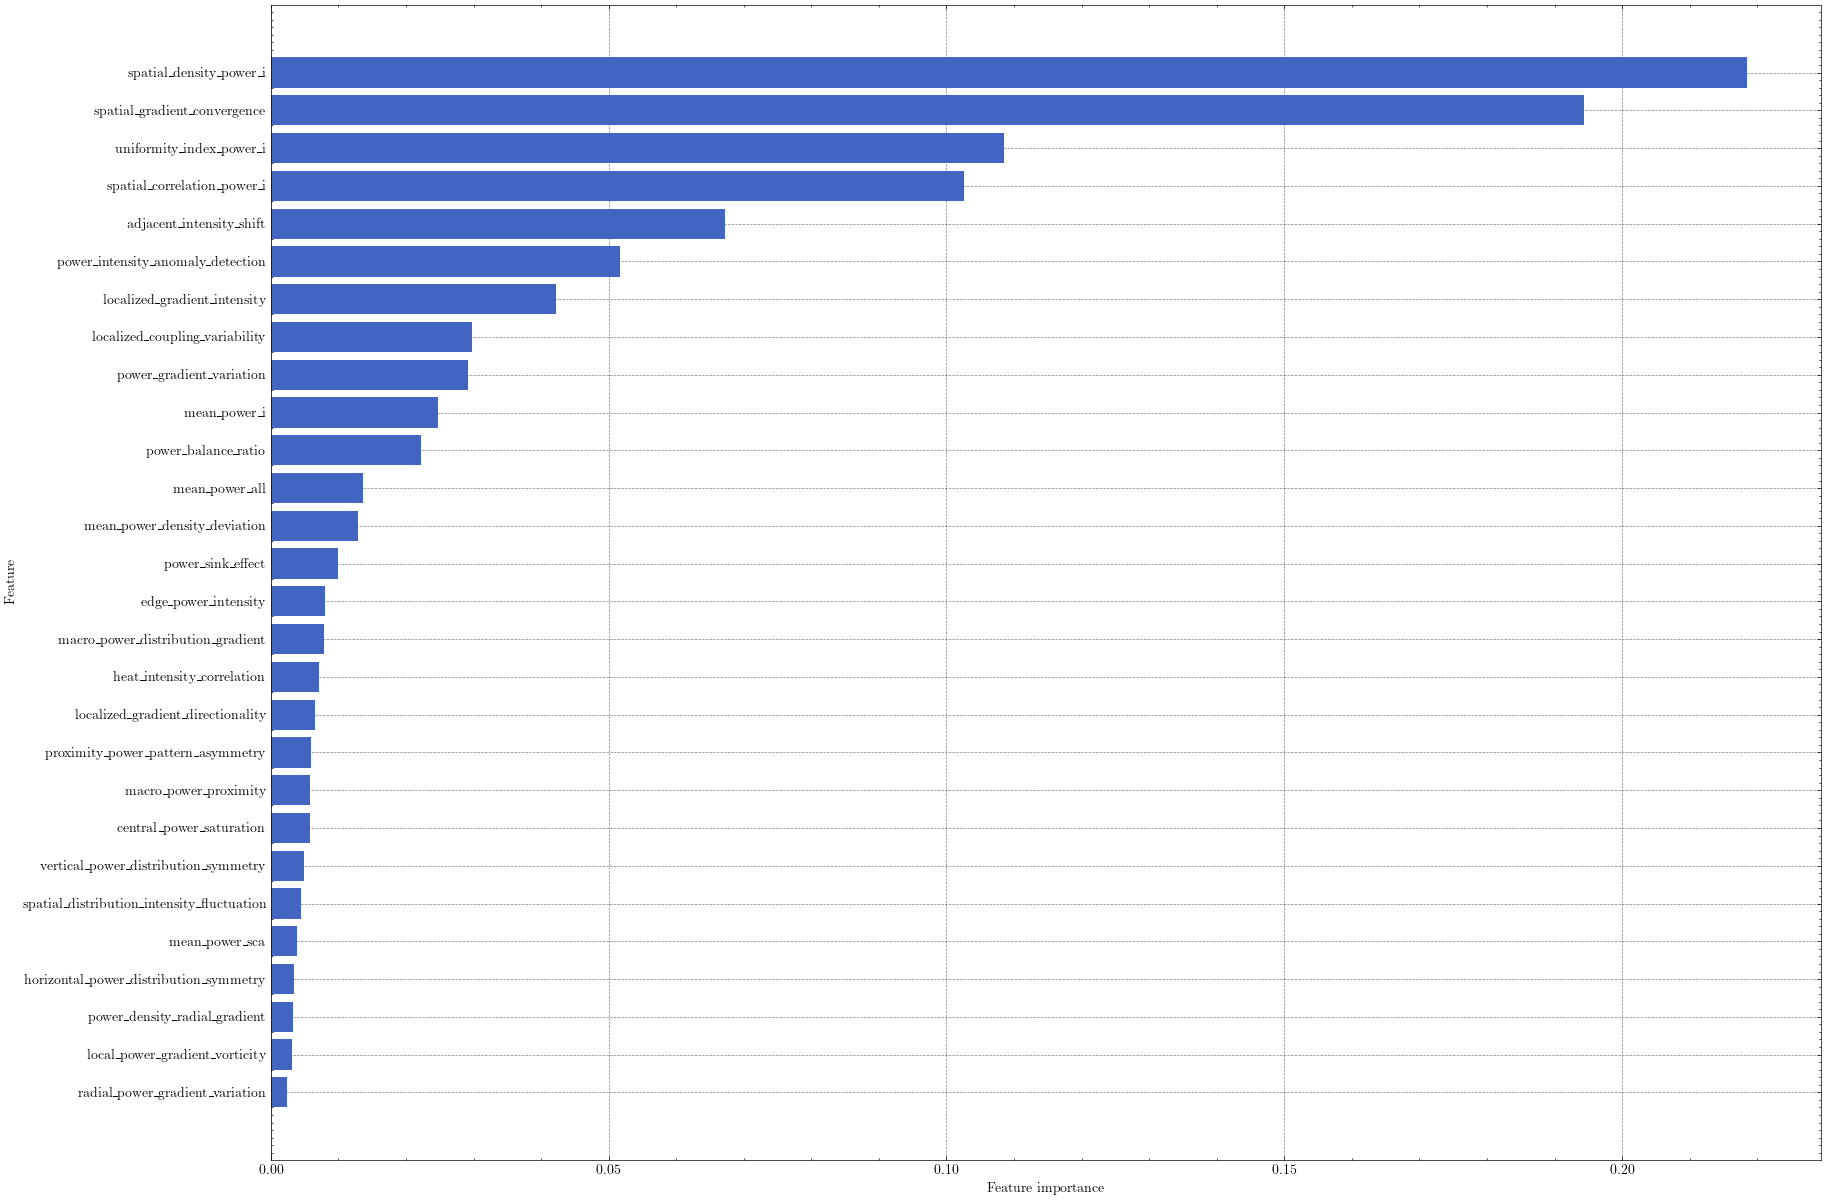

In [540]:
feature_importance = regressor.feature_importances_ 
sorted_idx = np.argsort(feature_importance) # Sort index on feature importance
fig = plt.figure(figsize=(20, 15)) # Set plot size (denoted in inches)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x.columns)[sorted_idx])

plt.xlabel("Feature importance") # Add x axis
plt.ylabel("Feature") # Add y axis

In [60]:
y_hat_a = regressor.predict(test_df_a.drop(columns=["id", "label"]))
y_hat_b = regressor.predict(test_df_b.drop(columns=["id", "label"]))
test_df_a["prediction"] = y_hat_a
test_df_b["prediction"] = y_hat_b

In [61]:
test_df_a = test_df_a.drop_duplicates(subset=["label"])
test_df_b = test_df_b.drop_duplicates(subset=["label"])

In [62]:
from scipy import stats
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
plt.style.use(['science','grid','retro'])

def replaceWithRank(arr):
    n = len(arr)
    res = [0] * n
    pq = []
    for i in range(n):
        heapq.heappush(pq, (arr[i], i))

    rank = 0
    lastNum = float('inf')

    while pq:
        curr, index = heapq.heappop(pq)

        if lastNum == float('inf') or curr != lastNum:
            rank += 1
            
        res[index] = rank - 1
        lastNum = curr

    return res

def evalute_corr(drc_set, predicted, corr_metrics):
    x = np.array(list(drc_set.values()))
    x_label = list(drc_set.keys())
    y = np.array([predicted[id] for id in x_label])
    results = {}
    if "PLCC" in corr_metrics:
        results["PLCC"] = stats.pearsonr(x, y)
    if "SRCC" in corr_metrics:
        results["SRCC"] = stats.spearmanr(x, y)
    if "KRCC" in corr_metrics:
        results["KRCC"] = stats.kendalltau(x, y)
    
    return results


def evaluate_design(df):
    drc_set = dict(zip(df["id"], df["label"]))
    drc_set = dict(sorted(drc_set.items(), key=lambda x: x[1]))
    predicted = dict(zip(df["id"], df["prediction"]))
    corr_metrics = ["PLCC", "SRCC", "KRCC"]
    results = evalute_corr(drc_set, predicted, corr_metrics)
    x = list(drc_set.keys())[::50]
    x = [name.split("-")[0] for name in x]
    x_label = list(range(0,len(x)))
    y = [predicted[file_path] for file_path in drc_set.keys()][::50]
    y_label = replaceWithRank(y)
    plt.figure(figsize=(10,5))
    plt.plot(x, y_label, linewidth="2", marker="o")
    plt.plot(x, x_label, linewidth="2", marker="o")
    plt.xticks(ticks=x_label, labels=x, rotation=90)
    plt.xlabel("Images")
    plt.ylabel("Rank Order")
    plt.title("DRC Violations Rank Order")
    plt.legend(["Predicted", "Ground Truth"])
    return results

#### Baseline

{'PLCC': PearsonRResult(statistic=np.float64(0.46136113481649443), pvalue=np.float64(1.8509803351543986e-95)),
 'SRCC': SignificanceResult(statistic=np.float64(0.47530822387192845), pvalue=np.float64(5.341606168871507e-102)),
 'KRCC': SignificanceResult(statistic=np.float64(0.3258062659122267), pvalue=np.float64(3.287902873564078e-95))}

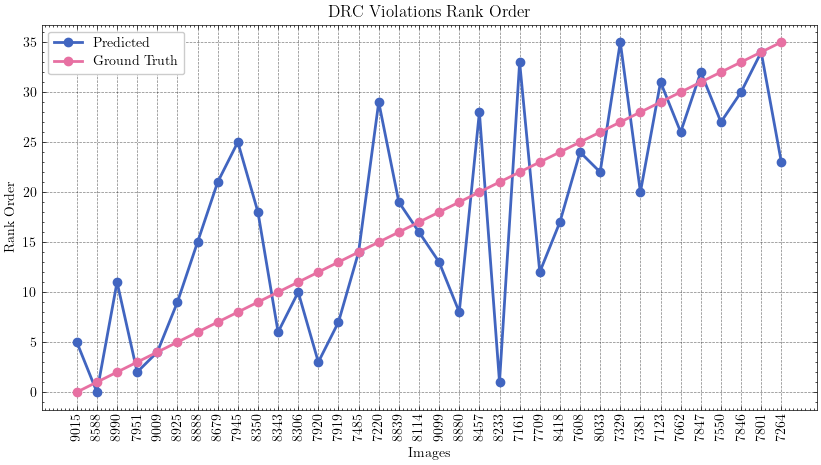

In [62]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.406547021123453), pvalue=np.float64(5.055795586389236e-37)),
 'SRCC': SignificanceResult(statistic=np.float64(0.11784310694551735), pvalue=np.float64(0.0004049988765297509)),
 'KRCC': SignificanceResult(statistic=np.float64(0.0788395785543814), pvalue=np.float64(0.0004078552185090071))}

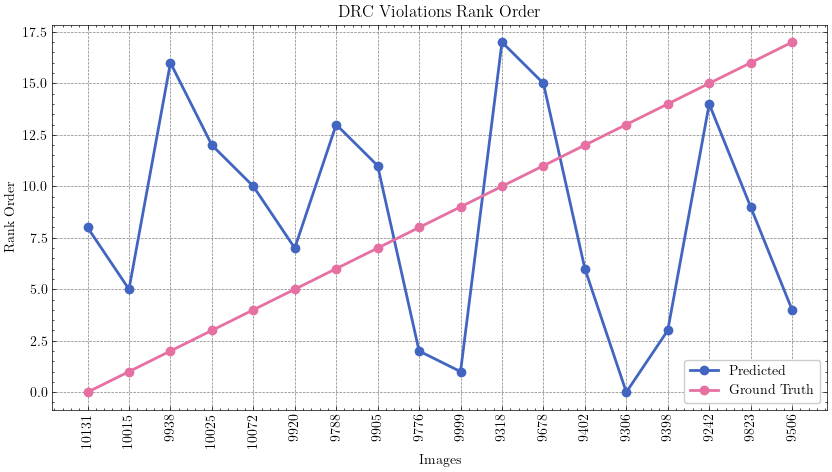

In [63]:
evaluate_design(test_df_b)

#### Stage 1.

{'PLCC': PearsonRResult(statistic=np.float64(0.909880776029317), pvalue=np.float64(0.0)),
 'SRCC': SignificanceResult(statistic=np.float64(0.9099928165218405), pvalue=np.float64(0.0)),
 'KRCC': SignificanceResult(statistic=np.float64(0.7502672542236072), pvalue=np.float64(0.0))}

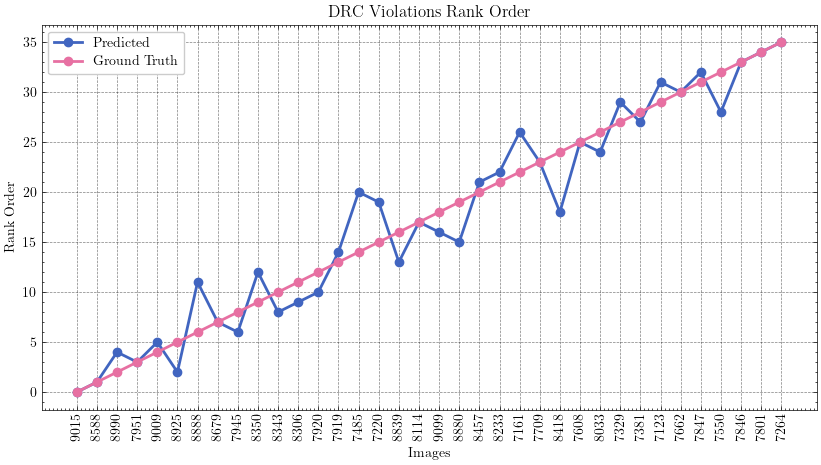

In [104]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.5869627125264673), pvalue=np.float64(3.674367516152733e-84)),
 'SRCC': SignificanceResult(statistic=np.float64(0.3577472550562543), pvalue=np.float64(1.794676656681048e-28)),
 'KRCC': SignificanceResult(statistic=np.float64(0.24407311094873443), pvalue=np.float64(7.1319744433291475e-28))}

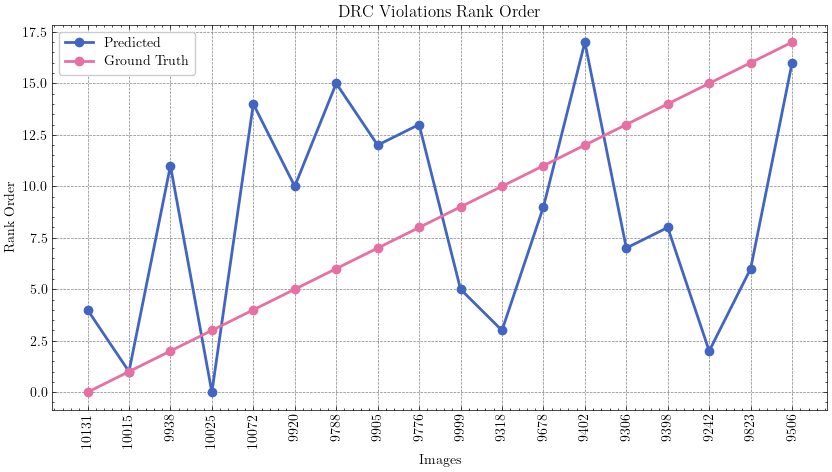

In [105]:
evaluate_design(test_df_b)

#### Stage 2.

{'PLCC': PearsonRResult(statistic=np.float64(0.9210826272206898), pvalue=np.float64(0.0)),
 'SRCC': SignificanceResult(statistic=np.float64(0.9221511140886804), pvalue=np.float64(0.0)),
 'KRCC': SignificanceResult(statistic=np.float64(0.7632523007547553), pvalue=np.float64(0.0))}

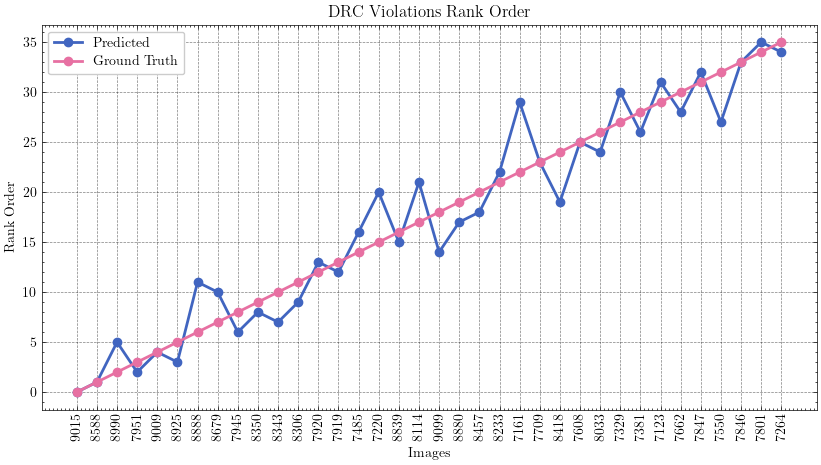

In [138]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.5794850323402825), pvalue=np.float64(1.3797745239186912e-81)),
 'SRCC': SignificanceResult(statistic=np.float64(0.30420047177589377), pvalue=np.float64(1.1651142901935413e-20)),
 'KRCC': SignificanceResult(statistic=np.float64(0.20440310263277597), pvalue=np.float64(4.9617889987574535e-20))}

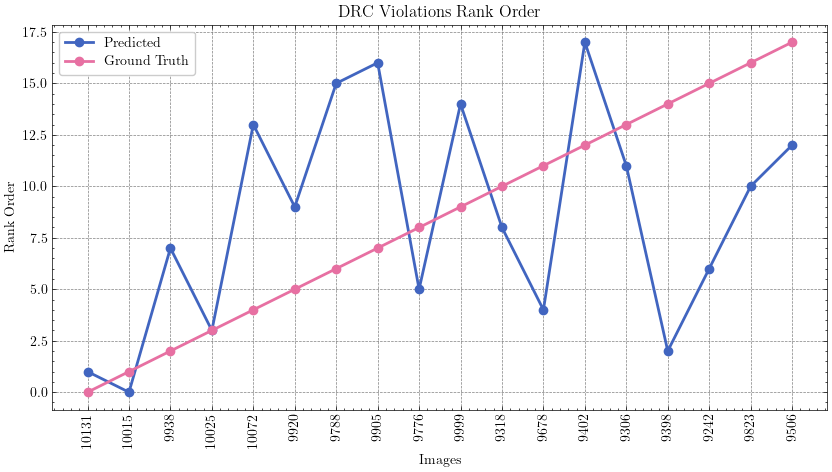

In [139]:
evaluate_design(test_df_b)

#### Stage 3.

{'PLCC': PearsonRResult(statistic=np.float64(0.9308182884044784), pvalue=np.float64(0.0)),
 'SRCC': SignificanceResult(statistic=np.float64(0.9310245525723615), pvalue=np.float64(0.0)),
 'KRCC': SignificanceResult(statistic=np.float64(0.7802801975607597), pvalue=np.float64(0.0))}

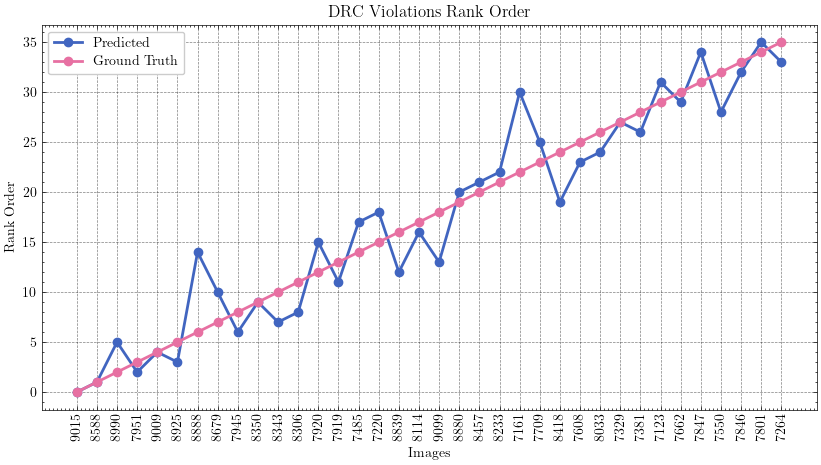

In [220]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.5863153961680381), pvalue=np.float64(6.176082633386734e-84)),
 'SRCC': SignificanceResult(statistic=np.float64(0.3209257027463994), pvalue=np.float64(6.186598783445713e-23)),
 'KRCC': SignificanceResult(statistic=np.float64(0.2174543273762239), pvalue=np.float64(1.8435703622731247e-22))}

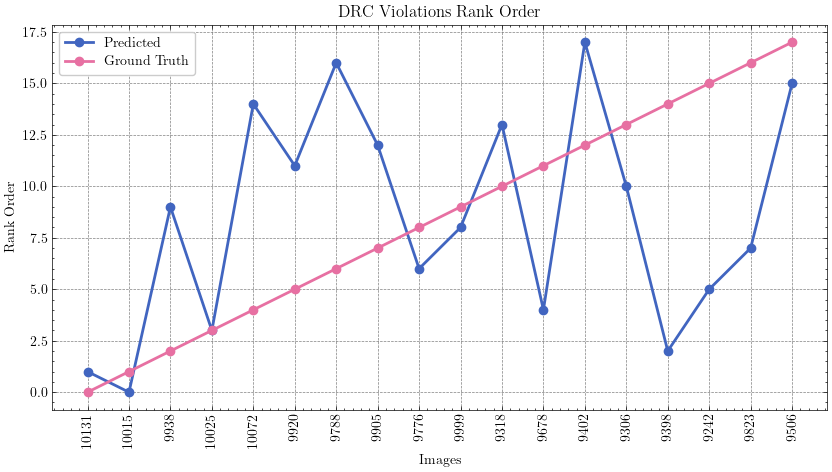

In [223]:
evaluate_design(test_df_b)

#### Stage 4.

{'PLCC': PearsonRResult(statistic=np.float64(0.933983563266322), pvalue=np.float64(0.0)),
 'SRCC': SignificanceResult(statistic=np.float64(0.9321032123451654), pvalue=np.float64(0.0)),
 'KRCC': SignificanceResult(statistic=np.float64(0.7832105542360491), pvalue=np.float64(0.0))}

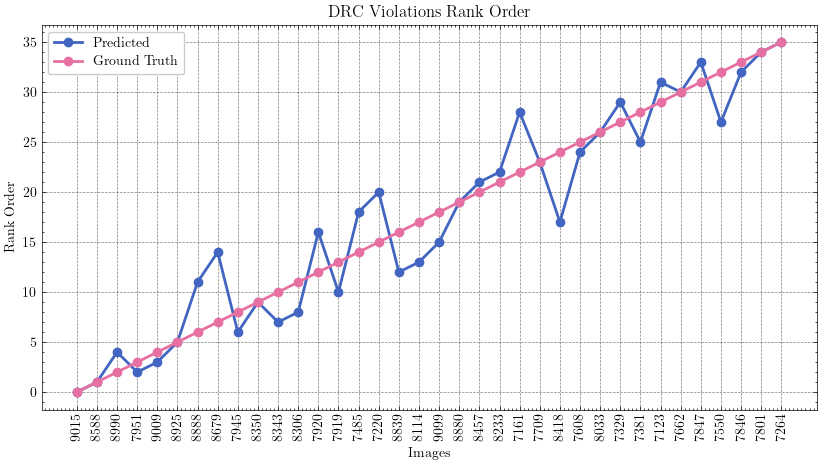

In [278]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.5741698065046201), pvalue=np.float64(8.507095990394818e-80)),
 'SRCC': SignificanceResult(statistic=np.float64(0.29130723285514937), pvalue=np.float64(5.274441962035389e-19)),
 'KRCC': SignificanceResult(statistic=np.float64(0.19823841713992246), pvalue=np.float64(6.195497908992591e-19))}

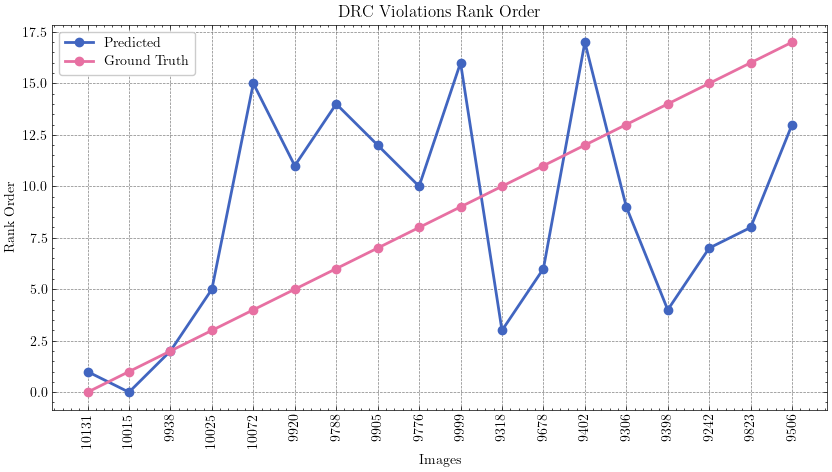

In [280]:
evaluate_design(test_df_b)

#### Stage 5.

{'PLCC': PearsonRResult(statistic=np.float64(0.9320804869128965), pvalue=np.float64(0.0)),
 'SRCC': SignificanceResult(statistic=np.float64(0.9296143560806194), pvalue=np.float64(0.0)),
 'KRCC': SignificanceResult(statistic=np.float64(0.779702154408735), pvalue=np.float64(0.0))}

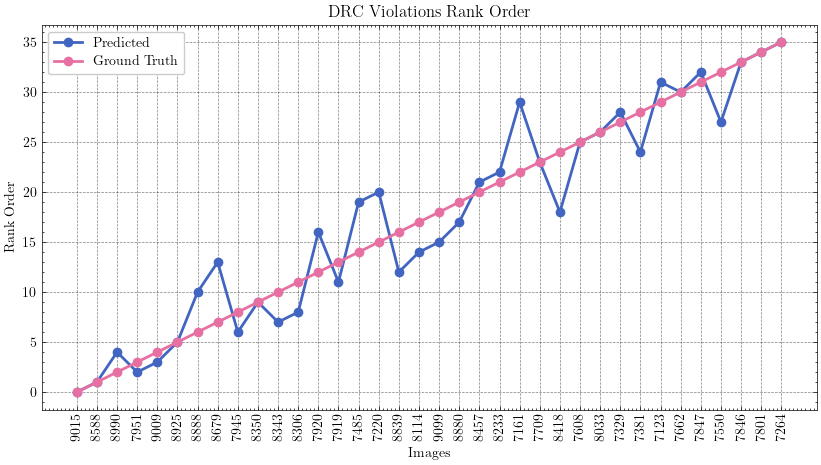

In [315]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.5917904137495057), pvalue=np.float64(7.362253751054657e-86)),
 'SRCC': SignificanceResult(statistic=np.float64(0.35529698730709924), pvalue=np.float64(4.42505718255507e-28)),
 'KRCC': SignificanceResult(statistic=np.float64(0.24438665687948155), pvalue=np.float64(6.106628962606612e-28))}

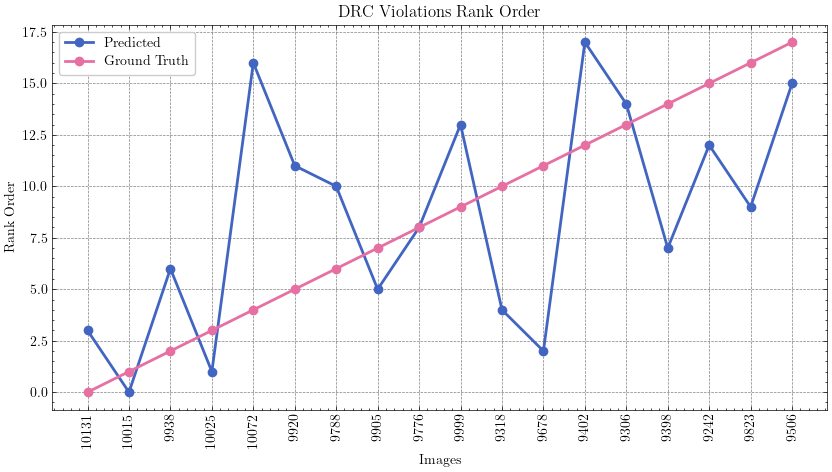

In [316]:
evaluate_design(test_df_b)

#### Stage 6

{'PLCC': PearsonRResult(statistic=np.float64(0.9305755599124954), pvalue=np.float64(0.0)),
 'SRCC': SignificanceResult(statistic=np.float64(0.9266619203335447), pvalue=np.float64(0.0)),
 'KRCC': SignificanceResult(statistic=np.float64(0.7749134480096912), pvalue=np.float64(0.0))}

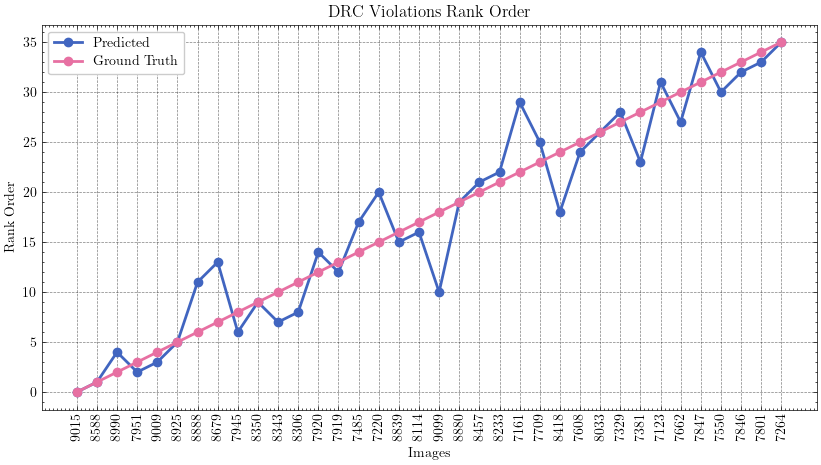

In [348]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.6314795877713065), pvalue=np.float64(5.58019958109095e-101)),
 'SRCC': SignificanceResult(statistic=np.float64(0.45181803733269005), pvalue=np.float64(2.475152468073906e-46)),
 'KRCC': SignificanceResult(statistic=np.float64(0.3133177721300755), pvalue=np.float64(7.890520288456112e-45))}

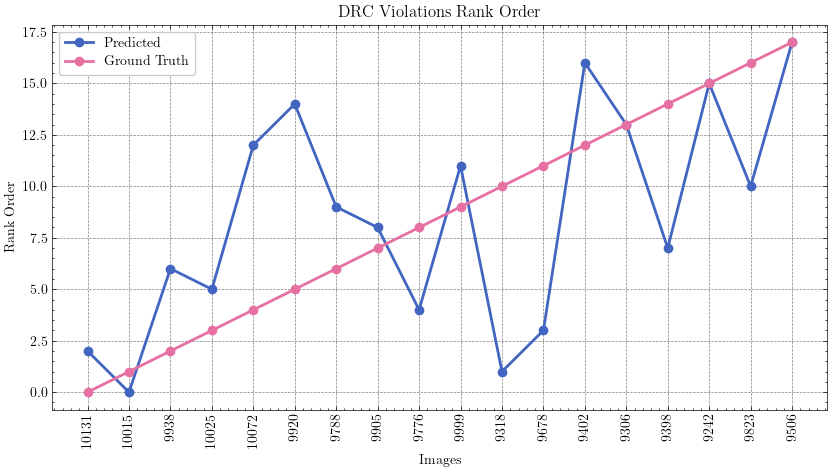

In [349]:
evaluate_design(test_df_b)

#### Stage 7

{'PLCC': PearsonRResult(statistic=np.float64(0.9306388858111359), pvalue=np.float64(0.0)),
 'SRCC': SignificanceResult(statistic=np.float64(0.926505973055034), pvalue=np.float64(0.0)),
 'KRCC': SignificanceResult(statistic=np.float64(0.7732929001060351), pvalue=np.float64(0.0))}

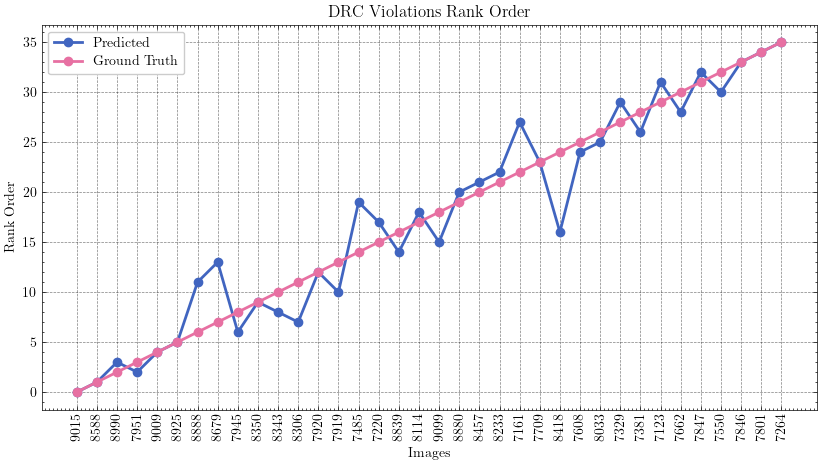

In [391]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.6034629450805905), pvalue=np.float64(4.36793116838786e-90)),
 'SRCC': SignificanceResult(statistic=np.float64(0.37466105401775057), pvalue=np.float64(2.841662289405715e-31)),
 'KRCC': SignificanceResult(statistic=np.float64(0.26002197312890096), pvalue=np.float64(2.072329700639805e-31))}

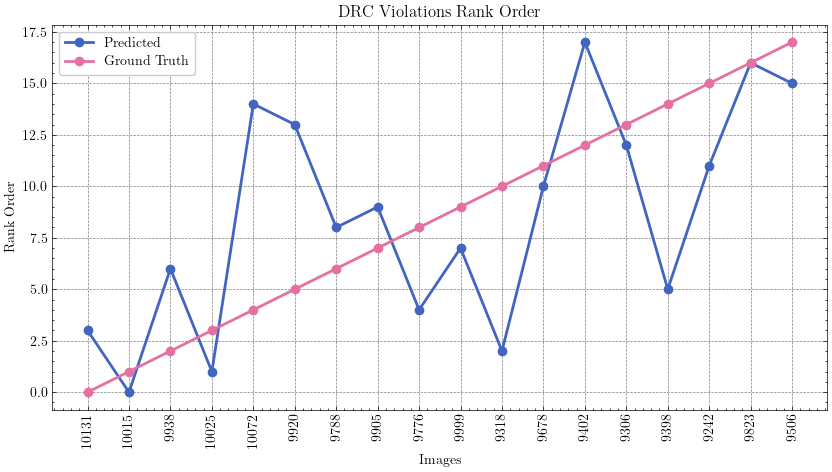

In [392]:
evaluate_design(test_df_b)

#### Stage 8

{'PLCC': PearsonRResult(statistic=np.float64(0.9344146330218872), pvalue=np.float64(0.0)),
 'SRCC': SignificanceResult(statistic=np.float64(0.930925222287413), pvalue=np.float64(0.0)),
 'KRCC': SignificanceResult(statistic=np.float64(0.7807131217686512), pvalue=np.float64(0.0))}

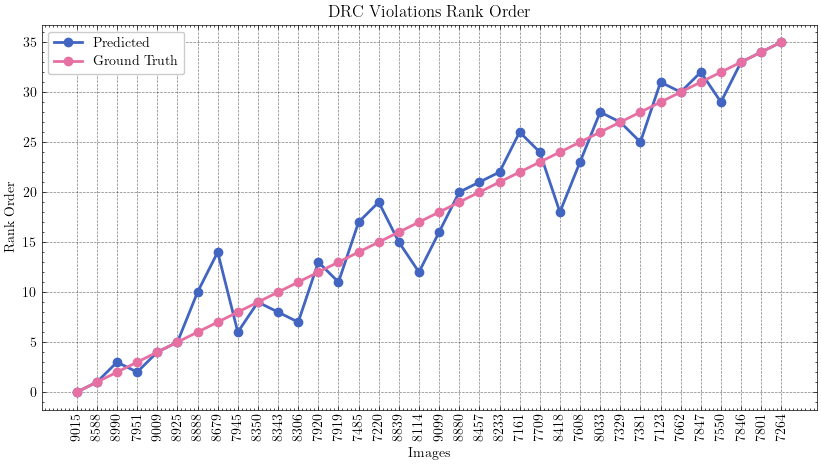

In [436]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.6374859500089456), pvalue=np.float64(1.832600013358547e-103)),
 'SRCC': SignificanceResult(statistic=np.float64(0.4498924129691789), pvalue=np.float64(6.5915566928509774e-46)),
 'KRCC': SignificanceResult(statistic=np.float64(0.30999528436503226), pvalue=np.float64(6.392248093867182e-44))}

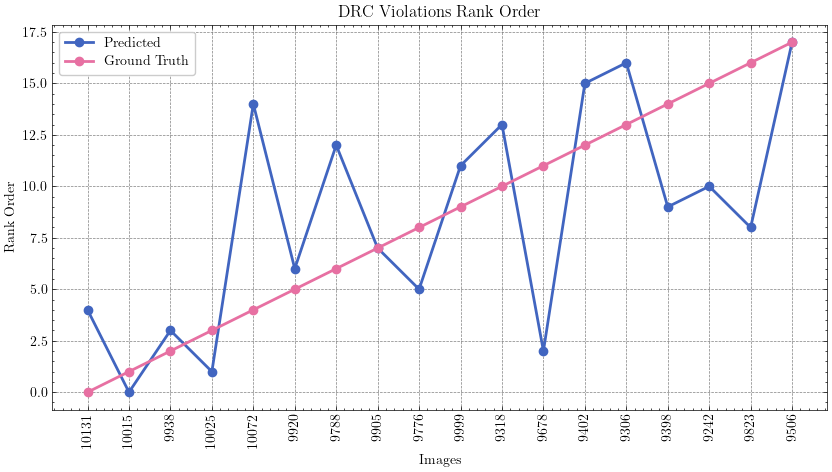

In [437]:
evaluate_design(test_df_b)

#### Stage 9

{'PLCC': PearsonRResult(statistic=np.float64(0.9336964170564617), pvalue=np.float64(0.0)),
 'SRCC': SignificanceResult(statistic=np.float64(0.9302470767219342), pvalue=np.float64(0.0)),
 'KRCC': SignificanceResult(statistic=np.float64(0.7795564474697284), pvalue=np.float64(0.0))}

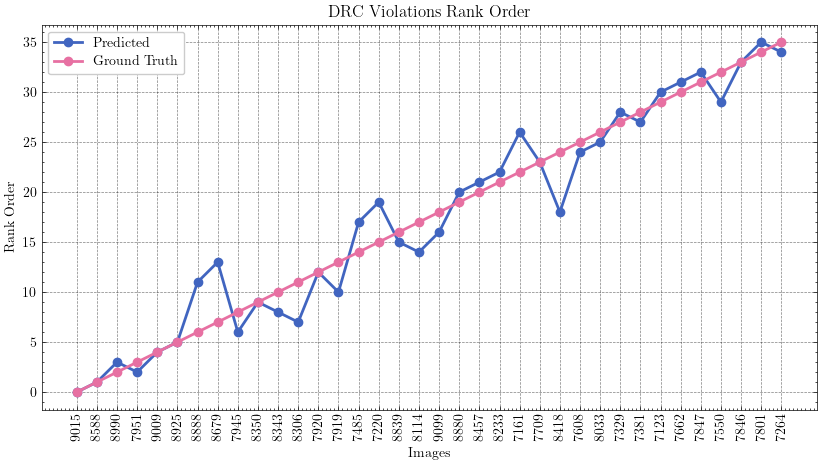

In [475]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.5732647044930093), pvalue=np.float64(1.703458890459447e-79)),
 'SRCC': SignificanceResult(statistic=np.float64(0.2832565478436581), pvalue=np.float64(5.174889088227497e-18)),
 'KRCC': SignificanceResult(statistic=np.float64(0.19542645410353027), pvalue=np.float64(1.9115149997876726e-18))}

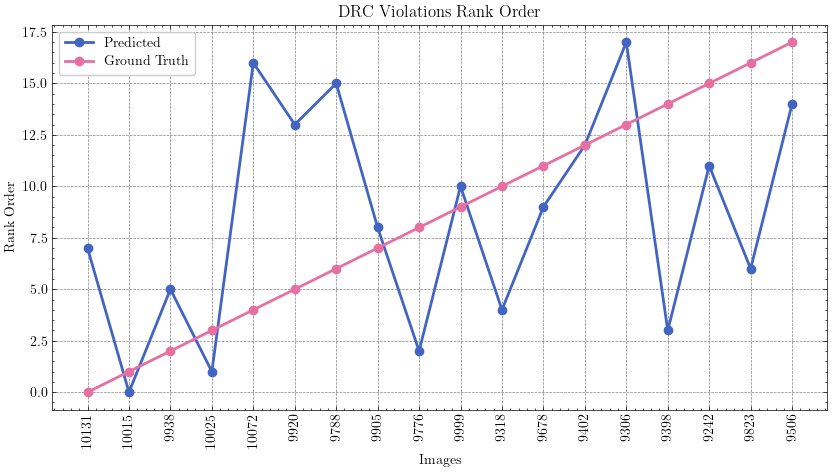

In [476]:
evaluate_design(test_df_b)

#### Stage 10

{'PLCC': PearsonRResult(statistic=np.float64(0.970132340496528), pvalue=np.float64(0.0)),
 'SRCC': SignificanceResult(statistic=np.float64(0.9720549880162211), pvalue=np.float64(0.0)),
 'KRCC': SignificanceResult(statistic=np.float64(0.856096831760758), pvalue=np.float64(0.0))}

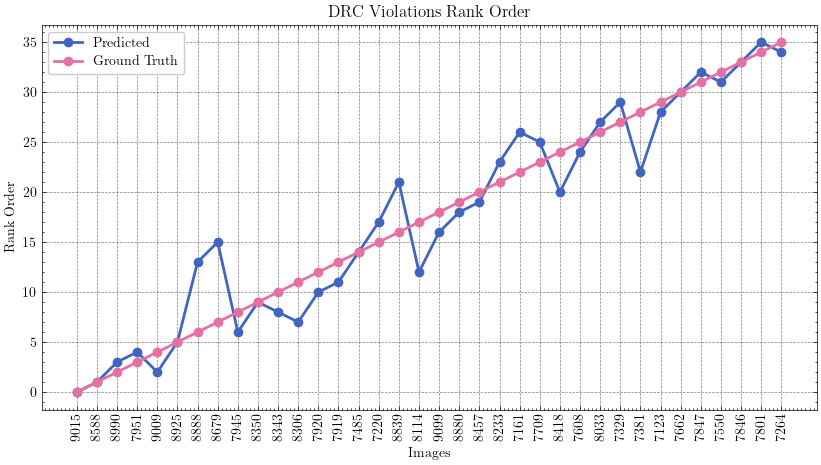

In [544]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.8269603256441657), pvalue=np.float64(5.037029036236285e-226)),
 'SRCC': SignificanceResult(statistic=np.float64(0.7640768719170755), pvalue=np.float64(1.4921636348160077e-172)),
 'KRCC': SignificanceResult(statistic=np.float64(0.5699486506970225), pvalue=np.float64(4.8296652642375596e-144))}

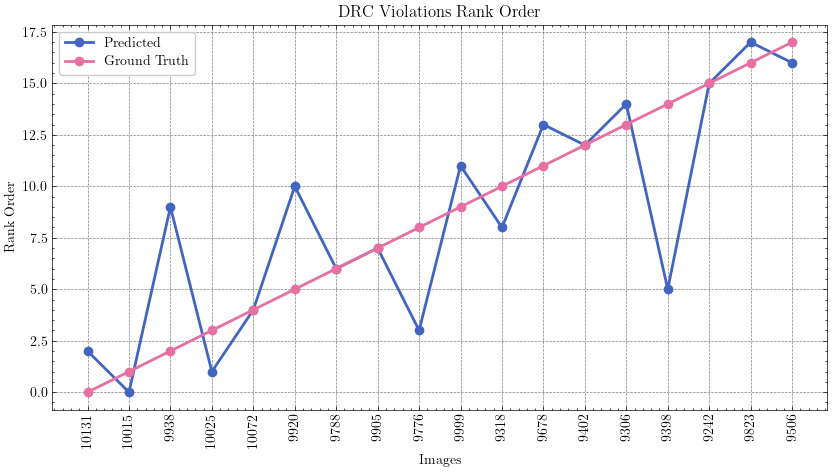

In [545]:
evaluate_design(test_df_b)

#### Genetic Algorithm

In [546]:
feat_importances = feature_importance[sorted_idx][-20:]
feat_pool = list(x.columns[sorted_idx])[-20:]

In [547]:
def forget_curve(t, S=20):
    return np.exp(-t/S)

In [548]:
feat_importances = {feat: imp for feat, imp in zip(feat_pool, feat_importances)}
feat_pool = {feat: desc[feat] for feat in feat_pool}
n = len(feat_pool)
feat_importances = {feat: forget_curve(n - i, n) for i, feat in enumerate(feat_importances.keys())}

In [549]:
import re
import requests
from prompt import CROSS_OVER_PROMPT, MUTATION_PROMPT, DEDUPLICATION_PROMPT, CODE_GEN_PROMPT

def prompt_selection(task_id, desc, feat_pool, feat_importances):
    if task_id == 0:
        prompts = [CROSS_OVER_PROMPT.format(existing_features=desc, feat_pool=feat_pool)]
    else:
        pd = np.random.uniform(0, 1, len(feat_importances))
        prompts = []
        for i, (feat, imp) in enumerate(feat_importances.items()):
            if pd[i] < imp:
                feat = {feat: desc[feat]}
                mutated_prompt = MUTATION_PROMPT.format(existing_features=desc, feature=feat)
                prompts.append(mutated_prompt)
    return prompts

def mllm_single_inference(prompt, type="json"):
    payload = {
    "model": "gpt-4o",
    "messages": [
        {
        "role": "user",
        "content": [
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[0]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[1]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[2]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[3]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[4]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[5]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[6]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[7]}"
            }
            },
            {
            "type": "text",
            "text": prompt,
            }
        ]
        }
    ],
    "max_tokens": 2000,
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    response = response.json()['choices'][0]['message']['content'] 
    pattern = r"```json([\s\S]*?)```" if type == "json" else r"```python([\s\S]*?)```"
    response = re.search(pattern, response).group(1).strip()
    print(response)
    return response

def feat_extractor(task_id, responses):
    if task_id == 0:
        new_feat = json.loads(responses[0])
    else:
        new_feat = {}
        for response in responses:
            new_feat.update(json.loads(response))
            
    return new_feat

def featgen_inference(prompts):
    responses = []
    for prompt in prompts:
        response = mllm_single_inference(prompt)
        responses.append(response)
    return responses

def deduplicator(feat_pool, new_feat):
    prompt = DEDUPLICATION_PROMPT.format(feat_pool=feat_pool, new_feat_pool=new_feat)
    response = mllm_single_inference(prompt)
    response = json.loads(response)
    dup_feat = [r["feature"] for r in response]
    no_dup_feat = {k: v for k, v in new_feat.items() if k not in dup_feat}
    return no_dup_feat

def code_gen(new_feats):
    responses = []
    for new_feat, definition in new_feats.items():
        prompt = CODE_GEN_PROMPT.format(feature={new_feat: definition}, feature_name=new_feat)
        response = mllm_single_inference(prompt, type="python")
        responses.append(response)
    return responses

In [481]:
task_ids ={0: "cross-over", 1: "mutation"}
task_prob =[0.5, 0.5] 

def genetic_instruct(feat_pool, feat_importances):
    task_id = np.random.choice(list(task_ids.keys()), p=task_prob)
    print(f"Task: {task_ids[task_id]}")
    prompts = prompt_selection(task_id, desc, feat_pool, feat_importances)
    responses = featgen_inference(prompts)
    new_feats = feat_extractor(task_id, responses)
    no_dup_feat = deduplicator(desc, new_feats)
    return no_dup_feat

In [482]:
new_feat_pool = genetic_instruct(feat_pool, feat_importances)

Task: mutation
{
    "radial_power_gradient_variation": "the variation in power gradient magnitude as a function of radial distance from the center of the layout, providing insights into IR Drop dynamics across different regions"
}
{
    "radial_power_intensity_gradient": "the gradient of power intensity from the center to the edges, indicating potential IR Drop pathways and affecting overall distribution dynamics"
}
{
  "vertical_asymmetry_intensity": "intensity of vertical power distribution asymmetry across the layout, indicating potential regions of IR Drop imbalance"
}
{
  "macro_power_distribution_gradient": "the rate of change in power distribution around macros, indicating areas where power flow is either rapidly increasing or decreasing"
}
{
  "spatial_gradient_convergence": "the degree to which power gradients converge or diverge spatially across the layout, impacting IR Drop uniformity"
}
{
  "adjacent_intensity_shift": "the magnitude and direction of shifts in power intensi

In [483]:
new_feat_pool

{'radial_power_gradient_variation': 'the variation in power gradient magnitude as a function of radial distance from the center of the layout, providing insights into IR Drop dynamics across different regions',
 'macro_power_distribution_gradient': 'the rate of change in power distribution around macros, indicating areas where power flow is either rapidly increasing or decreasing',
 'spatial_gradient_convergence': 'the degree to which power gradients converge or diverge spatially across the layout, impacting IR Drop uniformity',
 'adjacent_intensity_shift': 'the magnitude and direction of shifts in power intensity between directly adjacent regions of the layout',
 'local_power_gradient_vorticity': 'the swirling pattern of localized power gradients which might indicate rotational power distribution effects in the layout, affecting IR Drop dynamics',
 'localized_gradient_directionality': 'the predominant direction of power gradient variations within localized regions of the layout, influ

In [484]:
error_code = {
'sector_power_intensity_variation': 'variation in power intensity across different radial sectors of the layout for imbalance detection'
}
# code_feat = code_gen(error_code)
code_feat = code_gen(new_feat_pool)

import cv2
import numpy as np

def radial_power_gradient_variation(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]
    
    # Choose an image to calculate gradients
    power_image = power_all  # Aggregate power information

    # Calculate gradient magnitudes
    grad_x = cv2.Sobel(power_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(power_image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

    # Get the center point of the image
    center_x = power_image.shape[1] // 2
    center_y = power_image.shape[0] // 2

    # Create a radial distance matrix
    y_indices, x_indices = np.indices(power_image.shape)
    radial_distances = np.sqrt((x_indices - center_x)**2 + (y_indices - center_y)**2)

    # Bin the radial distances and calculate gradient variation in each bin
    bin_size = 10  # Set the bin s

#### Stage 1 Function

In [17]:
import cv2
import numpy as np

def variance_power_i(images):
    power_i = images[0]
    
    # Calculate the variance of the internal power image
    variance = np.var(power_i)
    
    return {"variance_power_i": variance}


def variance_power_s(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Calculate variance of the switching power image
    variance_s = np.var(power_s)

    return {"variance_power_s": variance_s}


def variance_power_sca(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]  # Toggle rate scaled power
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]
    
    # Compute the variance of the toggle rate scaled power
    variance_sca = np.var(power_sca)

    return {"variance_power_sca": variance_sca}


def variance_power_all(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]  # This is already provided directly as power_all
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Calculate variance of power_all
    variance = cv2.meanStdDev(power_all)[1]**2
    
    return {"variance_power_all": variance[0][0]}


def peak_power_t_6(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Find the peak (maximum) power value at time step 6
    peak_power_value = np.max(power_t_6)

    return {"peak_power_t_6": peak_power_value}


def peak_power_t_13(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Convert the `power_t_13` image to a numpy array with values scaled to [0, 255]
    power_t_13_scaled = (power_t_13 * 255).astype(np.uint8)
    
    # Find the peak power (maximum pixel value) at time step 13
    peak_power = cv2.minMaxLoc(power_t_13_scaled)[1] / 255.0
    
    return {"peak_power_t_13": peak_power}

def peak_power_t_19(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]
    
    # Convert the image to a NumPy array
    power_t_19_array = np.array(power_t_19)

    # Find the peak power value in the power_t_19 image
    peak_power_value = np.max(power_t_19_array)
    
    return {"peak_power_t_19": peak_power_value}


def spatial_density_power_i(images):
    power_i = images[0]
    
    # Normalize image to the range 0-255 for OpenCV processing
    power_i = np.uint8(power_i * 255)
    
    # Threshold the image to create a binary map of significant power regions
    _, binary_map = cv2.threshold(power_i, 1, 255, cv2.THRESH_BINARY)
    
    # Calculate the spatial density as the ratio of non-zero pixels to total pixels
    non_zero_count = np.count_nonzero(binary_map)
    total_pixels = binary_map.size
    spatial_density = non_zero_count / total_pixels
    
    return {"spatial_density_power_i": spatial_density}

def spatial_density_power_s(images):
    power_s = images[1]  # Extract the switching power image

    # Convert the power_s image to binary using a threshold to identify active regions
    # The threshold value can be adjusted depending on the application needs
    _, binary = cv2.threshold(power_s, 0.1, 1, cv2.THRESH_BINARY)

    # Calculate the spatial density as the ratio of active pixels to the total number of pixels
    total_pixels = power_s.size
    active_pixels = np.sum(binary)
    spatial_density = active_pixels / total_pixels

    return {"spatial_density_power_s": spatial_density}


def spatial_correlation_power_sca(images):
    # Extract the toggle rate scaled power image
    power_sca = images[2]
    
    # Ensure the image is in the right format for processing
    power_sca = np.array(power_sca, dtype=np.float32)
    
    # Compute the mean and standard deviation of the image
    mean_sca = np.mean(power_sca)
    std_sca = np.std(power_sca)
    
    # Normalize the image
    normalized_sca = (power_sca - mean_sca) / std_sca
    
    # Shift the image by one pixel to both directions horizontally and vertically
    shifted_right = np.roll(normalized_sca, shift=1, axis=1)
    shifted_down = np.roll(normalized_sca, shift=1, axis=0)
    
    # Compute the correlation in both shifted directions and average the result
    correlation_right = np.mean(normalized_sca * shifted_right)
    correlation_down = np.mean(normalized_sca * shifted_down)
    
    # Average of both directional correlations
    spatial_correlation = (correlation_right + correlation_down) / 2
    
    return {"spatial_correlation_power_sca": spatial_correlation}

In [18]:
new_feat_func_list = [
    variance_power_i,
    variance_power_s,
    variance_power_sca,
    variance_power_all,
    peak_power_t_6,
    peak_power_t_13,
    peak_power_t_19,
    spatial_density_power_i,
    spatial_density_power_s,
    spatial_correlation_power_sca
]

In [19]:
new_feat_func_list[9](image_features)

{'spatial_correlation_power_sca': np.float32(0.87737215)}

#### Stage 2 Function

In [20]:
def max_power_gradient(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Compute gradients for each image using Sobel operator
    gradients = []
    
    for img in [power_i, power_s, power_sca, power_all, power_t_6, power_t_13, power_t_19]:
        # Compute gradients in x and y directions
        grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

        # Calculate the gradient magnitude
        grad_mag = np.sqrt(grad_x**2 + grad_y**2)

        # Find maximum gradient in the current image
        max_grad = np.max(grad_mag)
        gradients.append(max_grad)

    # Determine the maximum gradient across all images
    max_power_gradient = max(gradients)

    return {"max_power_gradient": max_power_gradient}


def proximity_coupling_effect(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Convert images to numpy arrays
    power_i_array = np.array(power_i)
    power_s_array = np.array(power_s)
    power_sca_array = np.array(power_sca)
    power_all_array = np.array(power_all)
    power_t_6_array = np.array(power_t_6)
    power_t_13_array = np.array(power_t_13)
    power_t_19_array = np.array(power_t_19)
    
    # Compute differences between time step power images to find fluctuations
    fluctuation_6_13 = cv2.absdiff(power_t_6_array, power_t_13_array)
    fluctuation_13_19 = cv2.absdiff(power_t_13_array, power_t_19_array)
    
    # Calculate average fluctuation
    avg_fluctuation = (fluctuation_6_13 + fluctuation_13_19) / 2.0
    
    # Compute the standard deviation of power distributions
    std_all = np.std(power_all_array)
    
    # Define proximity coupling effect
    # High fluctuations and high standard deviation suggest stronger coupling effects
    coupling_effect_intensity = np.mean(avg_fluctuation) * std_all

    return {"proximity_coupling_effect": coupling_effect_intensity}


def critical_path_power_variation(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Normalize images to 0-255 range for consistency (though they are already within [0,1])
    power_all = (power_all * 255).astype(np.uint8)
    power_t_6 = (power_t_6 * 255).astype(np.uint8)
    power_t_13 = (power_t_13 * 255).astype(np.uint8)
    power_t_19 = (power_t_19 * 255).astype(np.uint8)

    # Detect edges to find the critical path using the Canny edge detector
    edges = cv2.Canny(power_all, 100, 200)

    # Calculate variance in power along edges
    power_values_along_edges = power_all[edges > 0]
    critical_path_power_variation = np.std(power_values_along_edges)

    return {"critical_path_power_variation": critical_path_power_variation}


def macro_power_proximity(images):
    # Extract the relevant images
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]
    
    # Calculate gradients to understand power distribution around macros
    grad_x = cv2.Sobel(power_all, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(power_all, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute the magnitude of the gradient
    gradient_magnitude = cv2.magnitude(grad_x, grad_y)
    
    # Normalize the gradient magnitude to analyze relative distribution
    normalized_magnitude = cv2.normalize(gradient_magnitude, None, 0, 1, cv2.NORM_MINMAX)
    
    # Calculate the mean proximity influence of power distribution
    # This metric gives a sense of variance or spread of power around macros
    macro_power_proximity_value = np.mean(normalized_magnitude)
    
    # Return the feature as a dictionary
    return {"macro_power_proximity": macro_power_proximity_value}


def edge_power_intensity(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Convert images to the format required by OpenCV (0-255 range)
    power_all_scaled = (power_all * 255).astype(np.uint8)

    # Detect edges using the Canny edge detector
    edges = cv2.Canny(power_all_scaled, threshold1=30, threshold2=100)

    # Calculate the intensity of the power along the edges
    edge_intensity_sum = np.sum(power_all[edges > 0])

    # Normalize the intensity by the number of edge pixels
    num_edge_pixels = np.sum(edges > 0)
    if num_edge_pixels > 0:
        edge_power_intensity = edge_intensity_sum / num_edge_pixels
    else:
        edge_power_intensity = 0

    return {"edge_power_intensity": edge_power_intensity}


def power_balance_ratio(images):
    # Extract the images
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Use the power_all for calculation as it's the sum of other powers
    img = power_all

    # Normalize the image to [0, 255] for thresholding
    img_scaled = np.uint8(img * 255)

    # Determine threshold using Otsu's method
    _, thresholded = cv2.threshold(img_scaled, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Calculate the sum of power for high and low intensity areas
    high_intensity_sum = np.sum(img[thresholded == 255])
    low_intensity_sum = np.sum(img[thresholded == 0])

    # Handle division by zero in case all pixels are in one category
    if high_intensity_sum + low_intensity_sum == 0:
        balance_ratio = 0
    else:
        balance_ratio = high_intensity_sum / (high_intensity_sum + low_intensity_sum)

    return {"power_balance_ratio": balance_ratio}

In [21]:
new_feat_func_list = [
   max_power_gradient,
   proximity_coupling_effect,
   critical_path_power_variation,
   macro_power_proximity,
   edge_power_intensity,
   power_balance_ratio
]

In [22]:
new_feat_func_list[5](image_features)

{'power_balance_ratio': np.float64(0.37311809182774064)}

#### Stage 3 Function

In [23]:
def power_gradient_variation(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Function to compute the gradient magnitude
    def gradient_magnitude(image):
        sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        magnitude = cv2.magnitude(sobelx, sobely)
        return magnitude

    # Compute the gradient magnitude for each power image
    gradients = [gradient_magnitude(img) for img in images]

    # Calculate the variation (standard deviation) in gradient magnitudes
    gradient_stack = np.stack(gradients, axis=0)
    gradient_variation = np.std(gradient_stack, axis=0)
    
    # Compute the overall variation value as mean of gradient variation
    feature_value = np.mean(gradient_variation)
    
    return {"power_gradient_variation": feature_value}


def interconnect_power_fluctuation(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Stack the power images from different time steps to create a 3D array
    power_stack = np.stack([power_t_6, power_t_13, power_t_19], axis=0)

    # Compute the standard deviation across time steps to find fluctuation
    fluctuation = np.std(power_stack, axis=0)

    # Calculate average fluctuation over the entire image
    interconnect_power_fluctuation_value = np.mean(fluctuation)

    return {"interconnect_power_fluctuation": interconnect_power_fluctuation_value}


def localized_power_variability(images):
    # Extract images
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]
    
    # Define a window size for local analysis
    window_size = 32  # You can adjust based on needs
    
    # Initialize list to store local power variability
    local_variability = []
    
    # Analyze each image
    for img in images:
        # Calculate local mean and squared mean
        local_mean = cv2.blur(img, (window_size, window_size))
        squared_img = img * img
        local_squared_mean = cv2.blur(squared_img, (window_size, window_size))
        
        # Calculate local variance
        local_variance = local_squared_mean - (local_mean ** 2)
        
        # Calculate the standard deviation (square root of variance)
        local_std_dev = np.sqrt(local_variance)
        
        # Aggregate the local variability
        variability = np.mean(local_std_dev)
        local_variability.append(variability)
    
    # Average the variability across all power images
    feature_value = np.mean(local_variability)
    
    return {"localized_power_variability": feature_value}


def power_sink_effect(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Step 1: Calculate the gradient magnitude of the power_all image to detect regions with high power changes
    grad_x = cv2.Sobel(power_all, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(power_all, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = cv2.magnitude(grad_x, grad_y)

    # Step 2: Assess the variations in power over time to identify sink regions
    power_difference_6_13 = power_t_13 - power_t_6
    power_difference_13_19 = power_t_19 - power_t_13

    # Step 3: Combine the gradient and power differences to highlight potential sink areas
    combined_effect = gradient_magnitude + np.abs(power_difference_6_13) + np.abs(power_difference_13_19)

    # Step 4: Normalize the result to keep values between 0 and 1
    power_sink_effect_value = cv2.normalize(combined_effect, None, 0, 1, cv2.NORM_MINMAX)

    return {"power_sink_effect": np.mean(power_sink_effect_value)}


def power_source_cluster(images):
    # Extract the relevant images
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Compute a combined power image by summing relevant power maps
    combined_power = power_i + power_s + power_sca + power_all + power_t_6 + power_t_13 + power_t_19

    # Normalize the combined power map to scale between 0 and 1 (if necessary)
    combined_power = cv2.normalize(combined_power, None, 0, 1, cv2.NORM_MINMAX)

    # Convert 0-1 float array to 0-255 uint8 image
    combined_power_uint8 = np.uint8(combined_power * 255)

    # Threshold the image to create a binary map of high power regions
    _, binary_map = cv2.threshold(combined_power_uint8, 127, 255, cv2.THRESH_BINARY)

    # Find contours of the high power regions
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate number of clusters
    num_clusters = len(contours)

    return {"power_source_cluster": num_clusters}


def transmission_line_power_effect(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Convert images to numpy arrays for processing
    power_i = np.array(power_i, dtype=np.float32)
    power_s = np.array(power_s, dtype=np.float32)
    power_sca = np.array(power_sca, dtype=np.float32)
    power_all = np.array(power_all, dtype=np.float32)
    power_t_6 = np.array(power_t_6, dtype=np.float32)
    power_t_13 = np.array(power_t_13, dtype=np.float32)
    power_t_19 = np.array(power_t_19, dtype=np.float32)

    # Combine different powers to observe overall effect
    combined_power = power_i + power_s + power_sca

    # Compute gradient magnitudes to observe transmission lines
    gradient_x = cv2.Sobel(combined_power, cv2.CV_64F, 1, 0, ksize=5)
    gradient_y = cv2.Sobel(combined_power, cv2.CV_64F, 0, 1, ksize=5)
    gradient_magnitude = cv2.magnitude(gradient_x, gradient_y)

    # Analyze the IR drop influence at each time step to see dynamic effects
    time_diff_6_13 = np.abs(power_t_13 - power_t_6)
    time_diff_13_19 = np.abs(power_t_19 - power_t_13)

    # Analyze correlation between regions with high gradient and time-based changes
    effect = np.mean(gradient_magnitude * (time_diff_6_13 + time_diff_13_19))

    # Normalize the effect
    transmission_line_power_effect = effect / np.max(gradient_magnitude)

    return {"transmission_line_power_effect": transmission_line_power_effect}

In [24]:
new_feat_func_list = [power_gradient_variation,
                     interconnect_power_fluctuation,
                     localized_power_variability,
                     power_sink_effect,
                     power_source_cluster,
                     transmission_line_power_effect]

In [25]:
new_feat_func_list[2](image_features)

/tmp/ipykernel_3891039/2799591968.py:78: RuntimeWarning: invalid value encountered in sqrt
  local_std_dev = np.sqrt(local_variance)


{'localized_power_variability': np.float64(nan)}

#### Stage 4 Function

In [26]:
def spatial_correlation_power_i(images):
    power_i = images[0]
    
    def calculate_spatial_correlation(image):
        # Compute the 2D Fourier Transform of the image
        f_transform = np.fft.fft2(image)
        f_shift = np.fft.fftshift(f_transform)
        
        # Compute the magnitude spectrum
        magnitude_spectrum = np.abs(f_shift)
        
        # Calculate the autocorrelation using inverse FFT of magnitude squared
        autocorrelation = np.fft.ifft2(magnitude_spectrum**2)
        
        # Shift zero frequency component back to center
        autocorrelation = np.fft.fftshift(autocorrelation)
        
        # Normalize the result
        autocorrelation = np.abs(autocorrelation)
        autocorrelation /= autocorrelation.max()
        
        # Calculate mean spatial correlation
        spatial_correlation = np.mean(autocorrelation)
        
        return spatial_correlation
    
    # Calculate the spatial correlation for internal power fluctuations
    spatial_correlation_value = calculate_spatial_correlation(power_i)
    
    return {"spatial_correlation_power_i": spatial_correlation_value}


def mean_angular_power_deviation(images):
    power_all = images[3]

    # Get the dimensions of the image
    height, width = power_all.shape

    # Calculate the center of the image
    center_x, center_y = width // 2, height // 2

    # Number of angular sectors
    num_sectors = 36  # this divides the circle into 36 parts, i.e., 10-degree each

    # Calculate the angle for each sector
    angles = np.linspace(0, 2 * np.pi, num_sectors + 1)

    # Stores mean power for each sector
    sector_means = []

    # Iterate over each angular sector
    for i in range(num_sectors):
        # Create a mask for the current sector
        mask = np.zeros_like(power_all, dtype=np.uint8)

        # Define the points for the sector
        angle1 = angles[i]
        angle2 = angles[i + 1]
        x1 = int(center_x + 1000 * np.cos(angle1))
        y1 = int(center_y + 1000 * np.sin(angle1))
        x2 = int(center_x + 1000 * np.cos(angle2))
        y2 = int(center_y + 1000 * np.sin(angle2))
        
        # Draw the sector using an approximation by a polygon
        cv2.line(mask, (center_x, center_y), (x1, y1), 1, thickness=1)
        cv2.line(mask, (center_x, center_y), (x2, y2), 1, thickness=1)
        cv2.line(mask, (x1, y1), (x2, y2), 1, thickness=1)
        cv2.floodFill(mask, None, (center_x, center_y), 1)

        # Calculate the mean power in the current sector
        masked_values = power_all[mask == 1]
        mean_power = np.mean(masked_values)
        sector_means.append(mean_power)

    # Compute the mean angular power deviation
    mean_sectors = np.mean(sector_means)
    angular_deviation = np.mean(np.abs(sector_means - mean_sectors))

    return {"mean_angular_power_deviation": angular_deviation}


def localized_coupling_variability(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    def calculate_variability(image):
        # Calculate gradients in x and y directions
        grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        
        # Calculate the magnitude of the gradients
        magnitude = cv2.magnitude(grad_x, grad_y)
        
        # Return the average variability across the image
        variability = np.mean(magnitude)
        return variability

    # Calculate the variability for each power image
    variability_i = calculate_variability(power_i)
    variability_s = calculate_variability(power_s)
    variability_sca = calculate_variability(power_sca)
    variability_all = calculate_variability(power_all)

    # Aggregate the variability values
    localized_variability = (variability_i + variability_s + variability_sca + variability_all) / 4

    return {"localized_coupling_variability": localized_variability}

def calculate_balance(image):
    # Threshold to distinguish between high and low intensity areas
    _, high_intensity = cv2.threshold(image, 0.5, 1, cv2.THRESH_BINARY)
    low_intensity = 1 - high_intensity

    high_intensity_area = np.sum(high_intensity)
    low_intensity_area = np.sum(low_intensity)

    if low_intensity_area == 0:
        return 0

    return high_intensity_area / low_intensity_area

def power_balance_flux(images):
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Calculate balance at given timesteps
    balance_t_6 = calculate_balance(power_t_6)
    balance_t_13 = calculate_balance(power_t_13)
    balance_t_19 = calculate_balance(power_t_19)
    
    # Calculate flux (rate of change) between timesteps
    flux_6_13 = balance_t_13 - balance_t_6
    flux_13_19 = balance_t_19 - balance_t_13

    # Average rate of change
    power_balance_flux = (flux_6_13 + flux_13_19) / 2

    return {"power_balance_flux": power_balance_flux}


def peripheral_power_variation(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Compute the gradient to identify edge-like structures, focusing on the peripheral areas
    def compute_edge_variation(image):
        edges = cv2.Canny((image * 255).astype(np.uint8), 100, 200)
        edge_count = np.sum(edges > 0)
        return edge_count

    # Calculate the variation for each image
    power_variations = [
        compute_edge_variation(power_i),
        compute_edge_variation(power_s),
        compute_edge_variation(power_sca),
        compute_edge_variation(power_all),
        compute_edge_variation(power_t_6),
        compute_edge_variation(power_t_13),
        compute_edge_variation(power_t_19),
    ]

    # Compute the peripheral power variation as the mean of all variations
    peripheral_power_variation = np.mean(power_variations)
    
    return {"peripheral_power_variation": peripheral_power_variation}


def localized_gradient_intensity(images):
    # Unpack images
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Initialize gradient intensity accumulator
    gradient_intensity_sum = 0

    # Iterate through each image to calculate gradient
    for image in [power_i, power_s, power_sca, power_all, power_t_6, power_t_13, power_t_19]:
        # Generate gradient maps using Sobel operator
        grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        
        # Calculate the gradient magnitude
        grad_magnitude = cv2.magnitude(grad_x, grad_y)
        
        # Sum gradient magnitudes over the image
        gradient_intensity_sum += np.sum(grad_magnitude)

    # Calculate the average gradient intensity for all images
    num_images = len(images)
    average_gradient_intensity = gradient_intensity_sum / num_images

    return {"localized_gradient_intensity": average_gradient_intensity}

In [27]:
new_feat_func_list = [spatial_correlation_power_i,
                     mean_angular_power_deviation,
                     localized_coupling_variability,
                     power_balance_flux,
                     peripheral_power_variation,
                     localized_gradient_intensity]

In [28]:
new_feat_func_list[0](image_features)

{'spatial_correlation_power_i': np.float64(0.27275996044110373)}

#### Stage 5 Function

In [29]:
def total_power_distribution_area(images):
    power_all = images[3]

    # Define a threshold for significant power distribution
    threshold = 0.1  # Adjust this threshold based on what's "significant"
    
    # Convert image to a binary mask where pixels above threshold are 1
    _, binary_mask = cv2.threshold(power_all, threshold, 1, cv2.THRESH_BINARY)
    
    # Calculate total area of significant power distribution
    total_area = np.sum(binary_mask)
    
    return {"total_power_distribution_area": total_area}


def critical_power_distribution_path(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Convert images to arrays (assuming they are already normalized to [0,1])
    image_arrays = [np.array(image) for image in images]
    
    # Threshold to determine critical power paths
    threshold = 0.8  # You might adjust this value based on your specific criteria
    
    # Find pixels that exceed the threshold in multiple images
    critical_paths = np.logical_and.reduce([(image > threshold) for image in image_arrays])
    
    # Count critical path pixels
    critical_path_count = np.sum(critical_paths)
    
    return {"critical_power_distribution_path": critical_path_count}


def central_power_saturation(images):
    # Extracting image data
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Combining the power images
    combined_power = (power_i + power_s + power_sca + power_all + power_t_6 + power_t_13 + power_t_19) / 7

    # Get the dimensions of the image
    height, width = combined_power.shape

    # Define the central region as the middle 50% of the image
    central_region = combined_power[int(0.25 * height):int(0.75 * height), int(0.25 * width):int(0.75 * width)]

    # Calculate the mean power in the central region
    central_power_mean = np.mean(central_region)

    # Calculate the overall mean power in the whole image
    overall_power_mean = np.mean(combined_power)

    # Calculate the central power saturation as a ratio
    central_power_saturation = central_power_mean / overall_power_mean if overall_power_mean != 0 else 0

    return {"central_power_saturation": central_power_saturation}


def interstitial_power_gap(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]
    
    # Sum all power-related images to get a comprehensive power map
    combined_power_map = power_i + power_s + power_sca + power_all + power_t_6 + power_t_13 + power_t_19
    
    # Normalize the combined power map to ensure values between 0 and 1
    combined_power_map = cv2.normalize(combined_power_map, None, 0, 1, cv2.NORM_MINMAX)
    
    # Threshold the power map to binary: high power regions vs low power regions
    _, high_power_regions = cv2.threshold(combined_power_map, 0.5, 1.0, cv2.THRESH_BINARY)
    
    # Invert to find low power regions
    low_power_regions = 1.0 - high_power_regions
    
    # Find contours on the low power regions to measure gaps
    contours, _ = cv2.findContours((low_power_regions * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the total gap area
    total_gap_area = sum(cv2.contourArea(contour) for contour in contours)
    
    # Calculate the proportion of the area as a feature
    interstitial_gap_proportion = total_gap_area / (combined_power_map.shape[0] * combined_power_map.shape[1])
    
    return {"interstitial_power_gap": interstitial_gap_proportion}


def uniformity_index_power_i(images):
    power_i = images[0]
    
    # Convert the image to a NumPy array if it's not already
    power_i_array = np.array(power_i, dtype=np.float32)
    
    # Calculate the mean and standard deviation of the power_i image
    mean_power_i = np.mean(power_i_array)
    std_power_i = np.std(power_i_array)
    
    # Calculate the uniformity index
    if mean_power_i != 0:
        uniformity_index = 1 / (std_power_i / mean_power_i)
    else:
        uniformity_index = 0  # Handle division by zero for a perfectly uniform image

    return {"uniformity_index_power_i": uniformity_index}


def island_power_effect(images):
    power_all = images[3]

    # Thresholding to find high power regions
    _, high_power_regions = cv2.threshold(power_all, 0.7, 1, cv2.THRESH_BINARY)

    # Finding contours to identify isolated regions (islands)
    contours, _ = cv2.findContours((high_power_regions * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Count the number of isolated high power regions (islands)
    num_islands = len(contours)

    # Calculate the percentage area covered by these islands
    total_area = power_all.shape[0] * power_all.shape[1]
    island_area = sum(cv2.contourArea(contour) for contour in contours)
    island_power_effect_value = (island_area / total_area) * 100

    return {"island_power_effect": island_power_effect_value}


def time_driven_power_variation(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]
    
    # Calculate the differences in power over time
    diff_t6_t13 = cv2.absdiff(power_t_6, power_t_13)
    diff_t13_t19 = cv2.absdiff(power_t_13, power_t_19)
    
    # Calculate variation metrics
    variation_t6_t13 = np.mean(diff_t6_t13)
    variation_t13_t19 = np.mean(diff_t13_t19)
    
    # Compute the overall variation as an average of time step variations
    time_driven_variation = (variation_t6_t13 + variation_t13_t19) / 2
    
    return {"time_driven_power_variation": time_driven_variation}

In [30]:
new_feat_func_list = [total_power_distribution_area,
                     critical_power_distribution_path,
                     central_power_saturation,
                     interstitial_power_gap,
                     uniformity_index_power_i,
                     island_power_effect,
                     time_driven_power_variation]

In [31]:
new_feat_func_list[0](image_features)

{'total_power_distribution_area': np.float64(4092.0)}

#### Stage 6 Function

In [32]:
def dynamic_power_distribution_shift(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Calculate the absolute difference between consecutive time step images
    diff_6_13 = cv2.absdiff(power_t_6, power_t_13)
    diff_13_19 = cv2.absdiff(power_t_13, power_t_19)
    
    # Calculate the overall shift by summing the differences
    shift_6_13 = np.sum(diff_6_13)
    shift_13_19 = np.sum(diff_13_19)
    
    # Calculate the average shift
    average_shift = (shift_6_13 + shift_13_19) / 2.0
    
    return {"dynamic_power_distribution_shift": average_shift}

def power_convergence_ratio(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Calculate the absolute differences between consecutive time steps
    diff_6_13 = cv2.absdiff(power_t_13, power_t_6)
    diff_13_19 = cv2.absdiff(power_t_19, power_t_13)

    # Compute the mean of the differences to get a sense of average change
    mean_diff_6_13 = np.mean(diff_6_13)
    mean_diff_13_19 = np.mean(diff_13_19)

    # Calculate the power convergence ratio
    # If mean_diff_6_13 is higher than mean_diff_13_19, power is converging
    if mean_diff_6_13 == 0:
        ratio = 0  # To avoid division by zero
    else:
        ratio = mean_diff_13_19 / mean_diff_6_13
    
    return {"power_convergence_ratio": ratio}


def heat_intensity_correlation(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    
    # Convert images to NumPy arrays if they are not already
    power_i = np.array(power_i, dtype=np.float32)
    power_s = np.array(power_s, dtype=np.float32)
    power_sca = np.array(power_sca, dtype=np.float32)
    power_all = np.array(power_all, dtype=np.float32)
    
    # Flatten the images for correlation calculation
    power_i_flat = power_i.flatten()
    power_s_flat = power_s.flatten()
    power_sca_flat = power_sca.flatten()
    power_all_flat = power_all.flatten()
    
    # Calculate correlation coefficients
    corr_i = np.corrcoef(power_i_flat, power_all_flat)[0, 1]
    corr_s = np.corrcoef(power_s_flat, power_all_flat)[0, 1]
    corr_sca = np.corrcoef(power_sca_flat, power_all_flat)[0, 1]
    
    # Average of the correlations as a simple metric
    heat_intensity_correlation_value = (corr_i + corr_s + corr_sca) / 3
    
    return {"heat_intensity_correlation": heat_intensity_correlation_value}


def voltage_stress_zone(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Normalize the images to the range [0, 255] for OpenCV processing
    power_all_255 = (power_all * 255).astype(np.uint8)
    
    # Threshold the power_all image to find high density regions
    # The threshold value can be adjusted based on the dataset characteristics
    _, thresh = cv2.threshold(power_all_255, 200, 255, cv2.THRESH_BINARY)

    # Find contours of the regions
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a mask to highlight the high density zones
    mask = np.zeros_like(power_all_255)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)

    # Calculate the proportion of the high density zones
    stress_zone_ratio = np.sum(mask) / (mask.shape[0] * mask.shape[1] * 255)

    return {"voltage_stress_zone": stress_zone_ratio}


def power_modulation_index(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Compute the difference in power at each time step relative to the total power
    diff_t_6 = cv2.absdiff(power_t_6, power_all)
    diff_t_13 = cv2.absdiff(power_t_13, power_all)
    diff_t_19 = cv2.absdiff(power_t_19, power_all)

    # Calculate the sum of the differences
    diff_sum = np.sum(diff_t_6) + np.sum(diff_t_13) + np.sum(diff_t_19)

    # Normalize the power modulation index by the total power
    total_power = np.sum(power_all)
    power_modulation_index_value = diff_sum / (3 * total_power)

    return {"power_modulation_index": power_modulation_index_value}

In [33]:
new_feat_func_list = [dynamic_power_distribution_shift,
                      power_convergence_ratio,
                     heat_intensity_correlation,
                     voltage_stress_zone,
                     power_modulation_index]

In [34]:
new_feat_func_list[4](image_features)

{'power_modulation_index': np.float64(0.7098311135253881)}

#### Stage 7 Function

In [35]:
def power_density_gradient(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Convert images to a 0-255 scale for processing
    power_all_scaled = (power_all * 255).astype(np.uint8)
    
    # Compute the gradient using the Sobel operator
    grad_x = cv2.Sobel(power_all_scaled, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(power_all_scaled, cv2.CV_64F, 0, 1, ksize=3)
    
    # Calculate the magnitude of the gradient
    gradient_magnitude = cv2.magnitude(grad_x, grad_y)
    
    # Normalize the gradient to a 0-1 range
    gradient_magnitude /= gradient_magnitude.max()

    # Calculate the mean of the gradient magnitude as a feature
    power_density_gradient_value = np.mean(gradient_magnitude)
    
    return {"power_density_gradient": power_density_gradient_value}


def temporal_power_alignment(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Calculate pairwise correlation between time steps
    corr_6_13 = np.corrcoef(power_t_6.flatten(), power_t_13.flatten())[0, 1]
    corr_13_19 = np.corrcoef(power_t_13.flatten(), power_t_19.flatten())[0, 1]

    # Average the correlations to assess temporal alignment
    temporal_power_alignment = (corr_6_13 + corr_13_19) / 2

    return {"temporal_power_alignment": temporal_power_alignment}


def localized_decay_zone(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Combine the power images over time to observe changes
    power_difference_1 = cv2.absdiff(power_t_6, power_t_13)
    power_difference_2 = cv2.absdiff(power_t_13, power_t_19)

    # Generate a decay mask by thresholding the differences
    _, decay_mask_1 = cv2.threshold(power_difference_1, 0.1, 1, cv2.THRESH_BINARY)
    _, decay_mask_2 = cv2.threshold(power_difference_2, 0.1, 1, cv2.THRESH_BINARY)

    # Combine decay masks to identify persistent decay zones
    combined_decay_mask = cv2.bitwise_and(decay_mask_1, decay_mask_2)

    # Find contours of the decay zones
    contours, _ = cv2.findContours(
        (combined_decay_mask * 255).astype(np.uint8), 
        cv2.RETR_EXTERNAL, 
        cv2.CHAIN_APPROX_SIMPLE
    )
    
    # Calculate areas of decay zones
    decay_zones_areas = [cv2.contourArea(cnt) for cnt in contours]

    # Feature: Total area of decay zones
    localized_decay_zone_area = np.sum(decay_zones_areas)

    return {"localized_decay_zone": localized_decay_zone_area}

def mean_power_density_deviation(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Calculate the mean power for each image
    mean_power_i = np.mean(power_i)
    mean_power_s = np.mean(power_s)
    mean_power_sca = np.mean(power_sca)
    mean_power_all = np.mean(power_all)
    mean_power_t_6 = np.mean(power_t_6)
    mean_power_t_13 = np.mean(power_t_13)
    mean_power_t_19 = np.mean(power_t_19)
    
    # Calculate deviations from the mean
    deviation_i = np.abs(power_i - mean_power_i)
    deviation_s = np.abs(power_s - mean_power_s)
    deviation_sca = np.abs(power_sca - mean_power_sca)
    deviation_all = np.abs(power_all - mean_power_all)
    deviation_t_6 = np.abs(power_t_6 - mean_power_t_6)
    deviation_t_13 = np.abs(power_t_13 - mean_power_t_13)
    deviation_t_19 = np.abs(power_t_19 - mean_power_t_19)

    # Average the deviations
    average_deviation = (
        np.mean(deviation_i) + 
        np.mean(deviation_s) + 
        np.mean(deviation_sca) + 
        np.mean(deviation_all) + 
        np.mean(deviation_t_6) + 
        np.mean(deviation_t_13) + 
        np.mean(deviation_t_19)
    ) / 7

    return {"mean_power_density_deviation": average_deviation}


def radial_power_distribution_variability(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]
    
    # Combine all power metrics to represent the overall power map
    combined_power = (power_i + power_s + power_sca + power_all + power_t_6 + power_t_13 + power_t_19) / 7

    # Get the dimensions of the image
    height, width = combined_power.shape
    
    # Calculate the center of the image
    center_x, center_y = width // 2, height // 2
    
    # Create a radial distance map from the center
    y_indices, x_indices = np.indices((height, width))
    radial_distances = np.sqrt((x_indices - center_x) ** 2 + (y_indices - center_y) ** 2)
    
    # Normalize radial distances to [0, 1]
    radial_distances /= radial_distances.max()
    
    # Calculate the variability in power distribution per radial bin
    num_bins = 100
    radial_bins = np.linspace(0, 1, num_bins)
    binned_variances = []

    # Calculate power variance for each radial bin
    for i in range(1, len(radial_bins)):
        mask = (radial_distances >= radial_bins[i-1]) & (radial_distances < radial_bins[i])
        if np.any(mask):
            binned_variances.append(combined_power[mask].var())
    
    # Calculate the average variability across all radial bins
    average_variability = np.mean(binned_variances)

    return {"radial_power_distribution_variability": average_variability}


def power_gradient_orientation(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]
    
    # Combine power maps for a comprehensive view
    combined_power_map = power_i + power_s + power_sca + power_all + power_t_6 + power_t_13 + power_t_19
    
    # Calculate gradients using Sobel operator
    grad_x = cv2.Sobel(combined_power_map, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(combined_power_map, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate gradient magnitude and angle
    magnitude, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)
    
    # Calculate histogram of gradient orientations
    hist, bin_edges = np.histogram(angle, bins=180, range=(0, 180))
    
    # Determine the dominant gradient orientation
    dominant_orientation = bin_edges[np.argmax(hist)]
    
    return {"power_gradient_orientation": dominant_orientation}

In [36]:
new_feat_func_list = [power_density_gradient,
                     temporal_power_alignment,
                     localized_decay_zone,
                     mean_power_density_deviation,
                     radial_power_distribution_variability,
                     power_gradient_orientation]

In [37]:
new_feat_func_list[5](image_features)

{'power_gradient_orientation': np.float64(0.0)}

#### Stage 8 Function

In [39]:
def cross_layer_power_interference(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Calculate the variance of power fluctuations across time steps
    power_variances = np.var([power_t_6, power_t_13, power_t_19], axis=0)

    # Calculate power layer interference as the variance of the sum of all power contributions
    layer_sums = power_i + power_s + power_sca
    cross_layer_interference = np.var(layer_sums + power_variances)

    return {"cross_layer_power_interference": cross_layer_interference}

def sector_power_intensity_variation(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Define number of sectors (e.g. using 8 sectors for simplicity)
    num_sectors = 8
    
    # Initialize a list to store intensity variations
    intensity_variations = []
    
    # Iterate over all images to calculate the variation
    for img in images:
        # Get image dimensions
        height, width = img.shape

        # Calculate center of the image
        center_x, center_y = width // 2, height // 2

        # Calculate the angle of each sector in radians
        angle_per_sector = 2 * np.pi / num_sectors

        # Collect average intensity of every sector
        sector_intensities = []

        for i in range(num_sectors):
            # Mask for the current sector
            mask = np.zeros_like(img, dtype=np.uint8)

            # Define angle range for the current sector
            start_angle = i * angle_per_sector
            end_angle = (i + 1) * angle_per_sector

            # Create a sector mask using cv2.ellipse
            cv2.ellipse(mask, (center_x, center_y), (center_x, center_y), 
                        0, np.degrees(start_angle), np.degrees(end_angle), 255, -1)

            # Apply mask to the image and calculate the mean intensity
            masked_img = cv2.bitwise_and(img, img, mask=mask)
            mean_intensity = cv2.mean(masked_img, mask=mask)[0]
            sector_intensities.append(mean_intensity)

        # Calculate the variation (e.g. standard deviation) of sector intensities
        variation = np.std(sector_intensities)
        intensity_variations.append(variation)

    # Calculate the average variation across all images
    feature_value = np.mean(intensity_variations)
    
    return {"sector_power_intensity_variation": feature_value}


def horizontal_power_distribution_symmetry(images):
    # Aggregate power values across all images
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Compute horizontal symmetry for a single image
    def compute_symmetry(image):
        # Flip the image horizontally
        flipped_image = cv2.flip(image, 1)
        
        # Compute symmetry as the sum of absolute differences
        symmetry = np.sum(np.abs(image - flipped_image))
        
        return symmetry
    
    # Compute the average symmetry across all power images
    symmetry_values = [
        compute_symmetry(power_i),
        compute_symmetry(power_s),
        compute_symmetry(power_sca),
        compute_symmetry(power_all),
        compute_symmetry(power_t_6),
        compute_symmetry(power_t_13),
        compute_symmetry(power_t_19),
    ]
    
    # Calculate the overall symmetry measure
    average_symmetry = np.mean(symmetry_values)
    
    return {"horizontal_power_distribution_symmetry": average_symmetry}


def vertical_power_distribution_symmetry(images):
    # Extract images
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Select the image to analyze; using power_all as an example
    image = power_all

    # Get the dimensions of the image
    height, width = image.shape

    # Split the image into left and right halves
    left_half = image[:, :width // 2]
    right_half = image[:, width // 2:]

    # Flip the right half horizontally
    right_half_flipped = cv2.flip(right_half, 1)

    # Calculate the absolute difference between the halves
    difference = np.abs(left_half - right_half_flipped)

    # Calculate symmetry score
    symmetry_score = 1 - np.sum(difference) / np.sum(image)

    # Normalize to make sure the result is between 0 and 1
    symmetry_score = np.clip(symmetry_score, 0, 1)

    return {"vertical_power_distribution_symmetry": symmetry_score}


def aggregate_power_fluctuation_intensity(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]
    
    # Calculate the mean power intensity for each time step image
    mean_powers = np.array([
        np.mean(power_t_6),
        np.mean(power_t_13),
        np.mean(power_t_19)
    ])
    
    # Calculate the variance of the mean power intensities
    fluctuation_intensity = np.var(mean_powers)
    
    return {"aggregate_power_fluctuation_intensity": fluctuation_intensity}


def power_intensity_anomaly_detection(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Calculate differences between power_all and individual components to detect anomalies
    diff_i = cv2.absdiff(power_all, power_i)
    diff_s = cv2.absdiff(power_all, power_s)
    diff_sca = cv2.absdiff(power_all, power_sca)
    
    # Calculate temporal differences to detect sudden changes
    temporal_diff_6_13 = cv2.absdiff(power_t_6, power_t_13)
    temporal_diff_13_19 = cv2.absdiff(power_t_13, power_t_19)

    # Aggregate anomaly indicators
    anomaly_indicator = (diff_i + diff_s + diff_sca +
                         temporal_diff_6_13 + temporal_diff_13_19)

    # Threshold the anomaly indicator to create a binary anomaly map
    _, anomaly_map = cv2.threshold(anomaly_indicator, 0.1, 1, cv2.THRESH_BINARY)

    # Calculate the feature value as the sum of anomaly map values
    feature_value = np.sum(anomaly_map)

    return {"power_intensity_anomaly_detection": feature_value}


def iterative_power_dissipation_rate(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Calculate the initial total power
    initial_power = power_all

    # Calculate the rate of power dissipation between time steps
    dissipation_rate_6 = (initial_power - power_t_6) / initial_power
    dissipation_rate_13 = (initial_power - power_t_13) / initial_power
    dissipation_rate_19 = (initial_power - power_t_19) / initial_power

    # Average the dissipation rates over the time steps
    average_dissipation_rate = np.mean([dissipation_rate_6, dissipation_rate_13, dissipation_rate_19])

    return {"iterative_power_dissipation_rate": average_dissipation_rate}

In [40]:
new_feat_func_list = [cross_layer_power_interference,
                     sector_power_intensity_variation,
                     horizontal_power_distribution_symmetry,
                     vertical_power_distribution_symmetry,
                     aggregate_power_fluctuation_intensity,
                     power_intensity_anomaly_detection,
                     iterative_power_dissipation_rate]

In [41]:
new_feat_func_list[6](image_features)

/tmp/ipykernel_3891039/1402015716.py:213: RuntimeWarning: invalid value encountered in divide
  dissipation_rate_6 = (initial_power - power_t_6) / initial_power
/tmp/ipykernel_3891039/1402015716.py:214: RuntimeWarning: invalid value encountered in divide
  dissipation_rate_13 = (initial_power - power_t_13) / initial_power
/tmp/ipykernel_3891039/1402015716.py:215: RuntimeWarning: invalid value encountered in divide
  dissipation_rate_19 = (initial_power - power_t_19) / initial_power


{'iterative_power_dissipation_rate': np.float64(nan)}

#### Stage 9 Function

In [42]:
def proximity_power_imbalance(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Compute the gradient magnitude as a measure of power imbalance
    sobel_x = cv2.Sobel(power_all, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(power_all, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

    # Sum the gradient magnitudes to get an overview of the imbalance
    imbalance_sum = np.sum(gradient_magnitude)

    # Scale the imbalance measure to a [0, 1] range, assuming max possible value for normalization
    max_possible_imbalance = np.sqrt((1.0**2 + 1.0**2) * gradient_magnitude.size)
    feature_value = imbalance_sum / max_possible_imbalance

    return {"proximity_power_imbalance": feature_value}


def diagonal_power_intensity(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    diagonal_means = []

    for img in images:
        # Convert image to grayscale if not already
        img_array = (img * 255).astype(np.uint8)
        
        # Extract the diagonal
        diagonal = np.diagonal(img_array)
        
        # Compute the mean of the diagonal
        mean_diagonal = np.mean(diagonal)
        
        diagonal_means.append(mean_diagonal)
    
    # Sum the means to get the overall diagonal power intensity
    diagonal_power_intensity_value = np.sum(diagonal_means)

    return {"diagonal_power_intensity": diagonal_power_intensity_value}


def power_distribution_interaction(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Convert images to arrays with intensity values between 0 and 255
    power_all_scaled = (power_all * 255).astype(np.uint8)

    # Apply a Gaussian blur to smooth the image and reduce noise
    blurred = cv2.GaussianBlur(power_all_scaled, (5, 5), 0)

    # Use Canny edge detection to find edges representing transitions between high and low power areas
    edges = cv2.Canny(blurred, 50, 150)

    # Count non-zero values (edge presence) which indicates interaction effect
    interaction_value = np.count_nonzero(edges)

    # Normalize the value by the total number of pixels to get a relative measure
    interaction_feature_value = interaction_value / edges.size

    return {"power_distribution_interaction": interaction_feature_value}


def proximity_power_pattern_asymmetry(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]
    
    # Function to calculate local asymmetry in a power map
    def calculate_asymmetry(image):
        # Compute Sobel gradients to find edges
        grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        
        # Compute the gradient magnitude
        mag = cv2.magnitude(grad_x, grad_y)
        
        # Normalize the gradient magnitude
        mag /= np.max(mag)
        
        # Calculate asymmetry by checking variance of gradient magnitudes 
        # in local neighborhoods
        asymmetry = cv2.Laplacian(mag, cv2.CV_64F)
        
        # Calculate the overall asymmetry as the standard deviation of 
        # the asymmetry map
        asymmetry_value = np.mean(np.abs(asymmetry))
        
        return asymmetry_value

    # Calculate asymmetry for each power map
    asymmetry_i = calculate_asymmetry(power_i)
    asymmetry_s = calculate_asymmetry(power_s)
    asymmetry_sca = calculate_asymmetry(power_sca)
    asymmetry_all = calculate_asymmetry(power_all)
    asymmetry_t_6 = calculate_asymmetry(power_t_6)
    asymmetry_t_13 = calculate_asymmetry(power_t_13)
    asymmetry_t_19 = calculate_asymmetry(power_t_19)

    # Compute a combined asymmetry value
    feature_value = (asymmetry_i + asymmetry_s + asymmetry_sca + asymmetry_all +
                     asymmetry_t_6 + asymmetry_t_13 + asymmetry_t_19) / 7

    return {"proximity_power_pattern_asymmetry": feature_value}


def interstitial_power_cluster(images):
    power_i = np.array(images[0], dtype=np.float32)
    power_s = np.array(images[1], dtype=np.float32)
    power_sca = np.array(images[2], dtype=np.float32)
    power_all = np.array(images[3], dtype=np.float32)
    power_t_6 = np.array(images[4], dtype=np.float32)
    power_t_13 = np.array(images[5], dtype=np.float32)
    power_t_19 = np.array(images[6], dtype=np.float32)
    
    # Summing the power images to get a combined effect
    combined_power = power_i + power_s + power_sca + power_all + power_t_6 + power_t_13 + power_t_19
    
    # Normalize the combined power image to [0, 255] for better visualization
    combined_power_normalized = cv2.normalize(combined_power, None, 0, 255, cv2.NORM_MINMAX)
    combined_power_normalized = np.uint8(combined_power_normalized)
    
    # Apply a Gaussian blur to smooth the image and reduce noise
    blurred = cv2.GaussianBlur(combined_power_normalized, (5, 5), 0)
    
    # Use a threshold to differentiate between dense clusters and sparse areas
    _, thresholded = cv2.threshold(blurred, 128, 255, cv2.THRESH_BINARY)
    
    # Find contours of the clusters
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the feature value as the number of power clusters
    interstitial_power_cluster_count = len(contours)
    
    return {"interstitial_power_cluster": interstitial_power_cluster_count}

In [43]:
new_feat_func_list = [proximity_power_imbalance,
                     diagonal_power_intensity,
                     power_distribution_interaction,
                     proximity_power_pattern_asymmetry,
                     interstitial_power_cluster]

In [44]:
new_feat_func_list[4](image_features)

{'interstitial_power_cluster': 0}

#### Stage 10 Function

In [45]:
def radial_power_gradient_variation(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]
    
    # Choose an image to calculate gradients
    power_image = power_all  # Aggregate power information

    # Calculate gradient magnitudes
    grad_x = cv2.Sobel(power_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(power_image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

    # Get the center point of the image
    center_x = power_image.shape[1] // 2
    center_y = power_image.shape[0] // 2

    # Create a radial distance matrix
    y_indices, x_indices = np.indices(power_image.shape)
    radial_distances = np.sqrt((x_indices - center_x)**2 + (y_indices - center_y)**2)

    # Bin the radial distances and calculate gradient variation in each bin
    bin_size = 10  # Set the bin size for radial analysis
    max_radius = int(np.max(radial_distances))
    radial_gradient_variation = []

    for r in range(0, max_radius, bin_size):
        mask = (radial_distances >= r) & (radial_distances < r + bin_size)
        gradient_values = gradient_magnitude[mask]
        if gradient_values.size > 0:
            variation = np.std(gradient_values)
            radial_gradient_variation.append(variation)
    
    # Calculate the overall variation
    feature_value = np.mean(radial_gradient_variation)

    return {"radial_power_gradient_variation": feature_value}


def macro_power_distribution_gradient(images):
    # Extract individual power-related images
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Compute gradients for the power_all image, which includes all contributions
    grad_x = cv2.Sobel(power_all, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(power_all, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate gradient magnitude
    grad_magnitude = cv2.magnitude(grad_x, grad_y)

    # Normalize the gradient magnitude to [0, 1] range
    grad_magnitude = cv2.normalize(grad_magnitude, None, 0, 1, cv2.NORM_MINMAX)
    
    # Calculate the average gradient value as a representation of distribution change
    avg_gradient = np.mean(grad_magnitude)
    
    return {"macro_power_distribution_gradient": avg_gradient}

def spatial_gradient_convergence(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Use the overall power map for the gradient computation
    power_map = power_all

    # Compute the gradients along the x and y axes
    grad_x = cv2.Sobel(power_map, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(power_map, cv2.CV_64F, 0, 1, ksize=3)

    # Compute the gradient magnitude and direction
    magnitude = cv2.magnitude(grad_x, grad_y)
    angle = cv2.phase(grad_x, grad_y, angleInDegrees=True)

    # Calculate convergence as the variance of gradient directions
    angle_variance = np.var(angle)

    return {"spatial_gradient_convergence": angle_variance}

def adjacent_intensity_shift(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Calculate the gradient for each image to find intensity shifts
    gradients = []
    for img in images:
        # Convert to 8-bit for gradient calculation
        img_8bit = (img * 255).astype(np.uint8)
        
        # Calculate gradients in the x and y directions
        grad_x = cv2.Sobel(img_8bit, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(img_8bit, cv2.CV_64F, 0, 1, ksize=3)
        
        # Calculate the magnitude of the gradient
        grad_magnitude = cv2.magnitude(grad_x, grad_y)
        
        gradients.append(grad_magnitude)

    # Calculate the average magnitude of gradients across all power images
    avg_gradient_magnitude = np.mean(gradients, axis=0)
    
    # Calculate the overall intensity shift as the mean of the gradient magnitudes
    feature_value = np.mean(avg_gradient_magnitude)
    
    return {"adjacent_intensity_shift": feature_value}

def local_power_gradient_vorticity(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Compute gradients for power_all image
    grad_x = cv2.Sobel(power_all, cv2.CV_64F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(power_all, cv2.CV_64F, 0, 1, ksize=5)

    # Compute the curl (vorticity) of the gradients
    # In a 2D field, the z-component of the curl is calculated as follows
    curl_z = grad_y - grad_x

    # Calculate the magnitude of vorticity
    vorticity_magnitude = np.sqrt(curl_z**2)

    # Find the swirling effect (mean of vorticity magnitude)
    local_power_gradient_vorticity = np.mean(vorticity_magnitude)

    return {"local_power_gradient_vorticity": local_power_gradient_vorticity}


def localized_gradient_directionality(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Compute gradients for each image
    gradients = []
    for img in images:
        # Compute x and y gradients
        grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

        # Compute the magnitude and angle of gradients
        magnitude, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)
        
        gradients.append((magnitude, angle))

    # Analyze predominant directionality from gradient angles
    directionality = np.zeros_like(images[0])
    
    for magnitude, angle in gradients:
        # Consider areas with significant gradient magnitude
        significant = magnitude > np.percentile(magnitude, 75)
        
        # Accumulate directionality (angle) where gradients are significant
        directionality[significant] += angle[significant]
    
    # Average directionality across images
    directionality /= len(images)

    # To obtain the predominant direction, calculate the mean angle
    mean_direction = np.mean(directionality)

    # Wrap result in a dictionary
    feature_value = {"localized_gradient_directionality": mean_direction}
    
    return feature_value


def spatial_distribution_intensity_fluctuation(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Function to compute fluctuation (standard deviation) in intensity distribution
    def compute_intensity_fluctuation(image):
        mean_intensity = np.mean(image)
        std_dev_intensity = np.std(image)
        fluctuation = std_dev_intensity / (mean_intensity + 1e-5)  # Avoid division by zero
        return fluctuation
    
    # Calculate fluctuation for each image
    fluctuations = [compute_intensity_fluctuation(img) for img in images]
    
    # Average fluctuation across all power images
    spatial_distribution_intensity_fluctuation = np.mean(fluctuations)
    
    return {"spatial_distribution_intensity_fluctuation": spatial_distribution_intensity_fluctuation}


def power_density_radial_gradient(images):
    power_i = images[0]
    power_s = images[1]
    power_sca = images[2]
    power_all = images[3]
    power_t_6 = images[4]
    power_t_13 = images[5]
    power_t_19 = images[6]

    # Stack all power-related images to compute an overall power density map
    power_map = power_i + power_s + power_sca + power_all + power_t_6 + power_t_13 + power_t_19
    
    # Get the dimensions
    rows, cols = power_map.shape
    
    # Calculate the coordinates of the center
    center = (cols / 2, rows / 2)

    # Create coordinate grid
    x = np.arange(cols) - center[0]
    y = np.arange(rows) - center[1]
    X, Y = np.meshgrid(x, y)

    # Calculate the distance from the center for each pixel
    distance_from_center = np.sqrt(X**2 + Y**2)

    # Compute the radial gradient
    radial_gradient = np.gradient(power_map, axis=(0, 1))
    
    # Normalize the gradient with respect to the distance from the center
    radial_gradient_magnitude = np.sqrt(radial_gradient[0]**2 + radial_gradient[1]**2)
    radial_gradient_normalized = radial_gradient_magnitude / (distance_from_center + 1e-6)  # Avoid division by zero

    # Take the mean value as the feature
    feature_value = np.mean(radial_gradient_normalized)

    return {"power_density_radial_gradient": feature_value}

In [46]:
new_feat_func_list = [radial_power_gradient_variation,
                     macro_power_distribution_gradient,
                     spatial_gradient_convergence,
                     adjacent_intensity_shift,
                     local_power_gradient_vorticity,
                     localized_gradient_directionality,
                     spatial_distribution_intensity_fluctuation,
                     power_density_radial_gradient]

In [47]:
new_feat_func_list[7](image_features)

{'power_density_radial_gradient': np.float64(0.0007806620899231678)}

#### Stage 11 Function

In [264]:
def macro_proximity_congestion_sensitivity(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate centroid of each macro
    macro_centroids = [cv2.moments(cnt) for cnt in contours]
    macro_centroids = [(int(m['m10']/m['m00']), int(m['m01']/m['m00'])) if m['m00'] != 0 else (0,0) for m in macro_centroids]
    
    # Calculate average distance between macros
    sum_distances = 0
    count = 0
    for i in range(len(macro_centroids)):
        for j in range(i + 1, len(macro_centroids)):
            dist = np.sqrt((macro_centroids[i][0] - macro_centroids[j][0]) ** 2 +
                           (macro_centroids[i][1] - macro_centroids[j][1]) ** 2)
            sum_distances += dist
            count += 1
    
    average_macro_distance = (sum_distances / count) * tiles_size if count > 0 else 0
    
    # Compute congestion level as average of congestion images
    congestion_images = [
        congestion_eGR_horizontal_overflow_image,
        congestion_eGR_vertical_overflow_image,
        congestion_GR_horizontal_overflow_image,
        congestion_GR_vertical_overflow_image
    ]
    total_congestion = np.mean(congestion_images)

    # Normalized sensitivity feature
    feature_value = total_congestion / average_macro_distance if average_macro_distance != 0 else 0
    
    return {"macro_proximity_congestion_sensitivity": feature_value}
import cv2
import numpy as np
from scipy.stats import skew

def cell_density_skewness(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate skewness of cell density
    cell_density_values = cell_density_image.flatten()
    cell_density_skewness = skew(cell_density_values)
    
    return {"cell_density_skewness": cell_density_skewness}


def inter_macro_path_complexity(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_long_image = images[2]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = (image_width * tiles_size) * (image_height * tiles_size)  # in um^2
    
    # Convert macro image to [0, 255] and threshold to find macros
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Create a combined congestion image
    congestion_image = (congestion_GR_horizontal_overflow_image + congestion_GR_vertical_overflow_image) / 2.0

    # Calculate path complexities (sum of congestion and rudy values)
    path_complexity_map = rudy_long_image + congestion_image
    
    # Sum of the path complexity values in the vicinity of macros
    path_complexity_sum = 0
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        macro_area = path_complexity_map[y:y+h, x:x+w]
        path_complexity_sum += np.sum(macro_area)

    # Consider path complexity per image area
    feature_value = path_complexity_sum / total_image_area
    
    return {"inter_macro_path_complexity": feature_value}


def macro_to_edge_strength(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Compute the edge proximity
    edge_proximity_strength = 0
    for contour in contours:
        for point in contour:
            x, y = point[0]
            # Calculate distance to nearest edge
            distance_to_edge = min(x, y, image_width - x - 1, image_height - y - 1)
            edge_proximity_strength += 1 / (distance_to_edge + 1)

    # Normalize by the number of macros
    if num_macros > 0:
        edge_proximity_strength /= num_macros
    
    # Convert the pixel-based measure to um
    edge_proximity_strength_um = edge_proximity_strength * tiles_size

    return {"macro_to_edge_strength": edge_proximity_strength_um}


def vertical_macro_proximity_ratio(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
   
    # Extract macro locations
    macro_centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            macro_centroids.append((cx, cy))
    
    # Compute average vertical and horizontal distances between macros
    vertical_distances = []
    horizontal_distances = []
    
    for i, (x1, y1) in enumerate(macro_centroids):
        for j, (x2, y2) in enumerate(macro_centroids):
            if i < j:
                vertical_distance = abs(y2 - y1) * tiles_size
                horizontal_distance = abs(x2 - x1) * tiles_size
                vertical_distances.append(vertical_distance)
                horizontal_distances.append(horizontal_distance)

    # Calculate average distances
    avg_vertical_distance = np.mean(vertical_distances) if vertical_distances else 0
    avg_horizontal_distance = np.mean(horizontal_distances) if horizontal_distances else 0
    
    # Calculate the vertical macro proximity ratio
    if avg_horizontal_distance != 0:
        feature_value = avg_vertical_distance / avg_horizontal_distance
    else:
        feature_value = 0  # To prevent division by zero
    
    return {"vertical_macro_proximity_ratio": feature_value}

import numpy as np
import cv2
from scipy.stats import skew

def cell_density_skewness_gradient(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Normalize cell_density_image to [0, 255] for visualization
    cell_density_image = (cell_density_image * 255).astype(np.uint8)

    # Calculate gradients using Sobel operator
    grad_x = cv2.Sobel(cell_density_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(cell_density_image, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate magnitude of gradients
    magnitude = np.sqrt(grad_x**2 + grad_y**2)

    # Calculate skewness of the gradient magnitudes
    skewness_gradient = skew(magnitude.flatten())

    # Convert skewness value to um (consider image resolution)
    feature_value = skewness_gradient * (tiles_size ** 2)
    
    return {"cell_density_skewness_gradient": feature_value}

In [265]:
new_feat_func_list = [macro_proximity_congestion_sensitivity,
                      cell_density_skewness,
                      inter_macro_path_complexity,
                      macro_to_edge_strength,
                      vertical_macro_proximity_ratio,
                      cell_density_skewness_gradient]

In [266]:
new_feat_func_list[5](image_features)

{'cell_density_skewness_gradient': np.float64(10.836382926838187)}

#### Stage 12 Function

In [319]:
def macro_interaction_perimeter(images):
    tile_size = 2.25
    macro_image = images[0]
    
    # Convert macro image to [0-255] scale
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to create a binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate total interaction perimeter
    interaction_perimeter = 0
    for contour in contours:
        # Approximate the contour to avoid small variations
        epsilon = 0.01 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # Calculate perimeter of the approximated contour
        perimeter = cv2.arcLength(approx, True)
        interaction_perimeter += perimeter

    # Convert perimeter from pixels to micrometers
    interaction_perimeter_um = interaction_perimeter * tile_size
    
    return {"macro_interaction_perimeter": interaction_perimeter_um}


def macro_cluster_dispersion(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))
    
    if len(centroids) < 2:
        return {"macro_cluster_dispersion": 0}
    
    distances = []
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            dist = np.sqrt((centroids[i][0] - centroids[j][0]) ** 2 + 
                           (centroids[i][1] - centroids[j][1]) ** 2)
            distances.append(dist)
    
    dispersion = np.std(distances) * tiles_size
    
    return {"macro_cluster_dispersion": dispersion}


def max_congestion_burst_radius(images):
    tiles_size = 2.25
    
    # Extract images
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    # Combine congestion images to get overall congestion
    combined_congestion = (
        congestion_eGR_horizontal_overflow_image +
        congestion_eGR_vertical_overflow_image +
        congestion_GR_horizontal_overflow_image +
        congestion_GR_vertical_overflow_image
    )
    
    # Normalize values to [0, 1] range just in case due to addition
    combined_congestion = np.clip(combined_congestion, 0, 1)
    
    # Threshold the congestion map to detect burst areas
    _, thresholded_congestion = cv2.threshold(
        np.uint8(combined_congestion * 255), 127, 255, cv2.THRESH_BINARY
    )
    
    # Find contours in the thresholded image
    contours, _ = cv2.findContours(
        thresholded_congestion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    
    # Calculate maximum congestion burst radius from the contours
    max_radius = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        radius = np.sqrt(area / np.pi)
        if radius > max_radius:
            max_radius = radius
    
    # Convert radius from pixels to micrometers
    max_congestion_burst_radius_um = max_radius * tiles_size
    
    return {"max_congestion_burst_radius": max_congestion_burst_radius_um}


def cell_density_fluctuation_balance(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    
    # Convert the macro image
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold for macro regions
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate standard deviation in cell density image
    cell_density_std = np.std(cell_density_image)

    # Identify regions of increasing and decreasing fluctuations
    high_fluctuation_mask = cell_density_image > np.mean(cell_density_image) + cell_density_std
    low_fluctuation_mask = cell_density_image < np.mean(cell_density_image) - cell_density_std
    
    # Calculate area for increasing and decreasing fluctuations
    increasing_fluctuation_area = np.sum(high_fluctuation_mask) * (tiles_size ** 2)
    decreasing_fluctuation_area = np.sum(low_fluctuation_mask) * (tiles_size ** 2)
    
    # Calculate balance
    fluctuation_balance = increasing_fluctuation_area / (decreasing_fluctuation_area + 1e-6)  # avoid division by zero

    return {"cell_density_fluctuation_balance": fluctuation_balance}


def congestion_pressure_fluctuation(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]

    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height

    # Convert macro_image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Calculate congestion fluctuation
    congestion_images = [
        congestion_eGR_horizontal_overflow_image,
        congestion_eGR_vertical_overflow_image,
        congestion_GR_horizontal_overflow_image,
        congestion_GR_vertical_overflow_image,
    ]

    fluctuation_totals = []

    for cong_img in congestion_images:
        mean, std_dev = cv2.meanStdDev(cong_img)
        fluctuation_totals.append(std_dev[0][0])

    average_fluctuation = np.mean(fluctuation_totals)
    
    # Calculate feature in um
    average_fluctuation_um = average_fluctuation * (tiles_size * image_width)

    feature_value = average_fluctuation_um

    return {"congestion_pressure_fluctuation": feature_value}


def orthogonal_cell_density_contrast(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    
    image_height, image_width = macro_image.shape
    
    # Convert macro image to uint8
    macro_image = np.uint8(macro_image * 255)
    
    # Find contours in macro image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate gradient to find orthogonal density changes
    sobelx = cv2.Sobel(cell_density_image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(cell_density_image, cv2.CV_64F, 0, 1, ksize=3)
    
    # Magnitude of the gradient
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    # Normalize gradient magnitude
    gradient_magnitude_normalized = cv2.normalize(gradient_magnitude, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    
    # Calculate the contrast in cell density
    contrast = np.sum(gradient_magnitude_normalized) / (image_height * image_width)
    
    # Convert pixel-based contrast to um-based contrast
    feature_value = contrast * (tiles_size**2) # Considering each pixel covers 2.25um x 2.25um
    
    return {"orthogonal_cell_density_contrast": feature_value}


def macro_boundary_constriction(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    constriction_areas = []
    
    for i in range(num_macros):
        for j in range(i + 1, num_macros):
            x1, y1, w1, h1 = cv2.boundingRect(contours[i])
            x2, y2, w2, h2 = cv2.boundingRect(contours[j])
            
            # Calculate the horizontal and vertical distances between macros
            horizontal_gap = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
            vertical_gap = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
            
            # If macros overlap along both axes, the gap is a constriction
            if horizontal_gap >= 0 and vertical_gap >= 0:
                constriction_areas.append(horizontal_gap * vertical_gap)
    
    # Convert pixel area to micrometers squared
    constriction_area_um2 = sum(constriction_areas) * (tiles_size ** 2)
    
    # Calculate the degree of constriction (as a percentage of the total area)
    feature_value = (constriction_area_um2 / (total_image_area * (tiles_size ** 2))) * 100
    
    return {"macro_boundary_constriction": feature_value}


def congestion_variability_throughout_hierarchy(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255] and binarize
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Compute congestion variability across hierarchical images
    congestion_images = [
        congestion_eGR_horizontal_overflow_image, 
        congestion_eGR_vertical_overflow_image,
        congestion_GR_horizontal_overflow_image, 
        congestion_GR_vertical_overflow_image
    ]
    
    congestion_variability = []
    
    for img in congestion_images:
        non_zero_congestion = img[img > 0]  # Get non-zero congestion values
        if len(non_zero_congestion) > 0:
            variability = np.std(non_zero_congestion) / np.mean(non_zero_congestion)
            congestion_variability.append(variability)
    
    avg_congestion_variability = np.mean(congestion_variability) if congestion_variability else 0
    
    # The feature is the average variability converted to the area unit
    feature_value = avg_congestion_variability * tiles_size**2
    
    return {"congestion_variability_throughout_hierarchy": feature_value}

In [320]:
new_feat_func_list = [macro_interaction_perimeter,
                      macro_cluster_dispersion,
                      max_congestion_burst_radius,
                      cell_density_fluctuation_balance,
                      congestion_pressure_fluctuation,
                      orthogonal_cell_density_contrast,
                      macro_boundary_constriction,
                      congestion_variability_throughout_hierarchy]

In [323]:
new_feat_func_list[7](image_features)

{'congestion_variability_throughout_hierarchy': np.float64(1.503345618487299)}

#### Stage 13 Function

In [374]:
def max_congestion_diffusion(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Combine congestion images by taking the maximum congestion level for each pixel
    combined_congestion = np.maximum.reduce([
        congestion_eGR_horizontal_overflow_image,
        congestion_eGR_vertical_overflow_image,
        congestion_GR_horizontal_overflow_image,
        congestion_GR_vertical_overflow_image
    ])
    
    # Threshold to find high congestion areas
    _, high_congestion = cv2.threshold(combined_congestion, 0.5, 1.0, cv2.THRESH_BINARY)
    
    # Find the maximum distance in high congestion areas using distance transform
    dist_transform = cv2.distanceTransform(np.uint8(high_congestion), cv2.DIST_L2, 5)
    max_distance_in_pixels = np.max(dist_transform)
    
    # Convert from pixels to um
    max_distance_um = max_distance_in_pixels * tiles_size

    return {"max_congestion_diffusion": max_distance_um}


def macro_silhouette_effect(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height * (tiles_size ** 2)
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate total contour length and interaction with congestion
    total_contour_length = 0
    total_congestion_interaction = 0
    
    for contour in contours:
        # Calculate contour length in micrometers
        contour_length_pixels = cv2.arcLength(contour, True)
        contour_length_um = contour_length_pixels * tiles_size
        total_contour_length += contour_length_um
        
        # Create a mask for the current macro contour
        mask = np.zeros_like(macro_image)
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
        
        # Calculate interaction with congestion images
        for congestion_image in [congestion_eGR_horizontal_overflow_image,
                                 congestion_eGR_vertical_overflow_image,
                                 congestion_GR_horizontal_overflow_image,
                                 congestion_GR_vertical_overflow_image]:
            interaction = np.sum(congestion_image[mask == 255])
            total_congestion_interaction += interaction
    
    # Calculate the macro silhouette effect
    effect_ratio = total_congestion_interaction / (total_contour_length + 1e-9)  # avoid division by zero
    
    return {"macro_silhouette_effect": effect_ratio}

def cell_density_spectrum_width(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the range of cell density values
    min_density = np.min(cell_density_image)
    max_density = np.max(cell_density_image)
    
    # Calculate the width of the cell density spectrum
    density_range = max_density - min_density
    
    # Convert to area units (um), considering tile size and image resolution
    density_range_um = density_range * (tiles_size * image_height / 256)
    
    return {"cell_density_spectrum_width": density_range_um}


def congestion_transition_amplitude(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    
    # Concatenate all congestion images into a single stack
    congestion_images = [
        congestion_eGR_horizontal_overflow_image, congestion_eGR_vertical_overflow_image,
        congestion_GR_horizontal_overflow_image, congestion_GR_vertical_overflow_image
    ]

    # Calculate the gradient (Sobel) to find edges representing congestion transitions
    transition_magnitudes = []
    for img in congestion_images:
        sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
        
        # Calculate the magnitude of the gradient
        magnitude = cv2.magnitude(sobel_x, sobel_y)
        transition_magnitudes.append(np.sum(magnitude))
    
    # Calculate the mean transition amplitude for the entire layout
    avg_transition_amplitude = np.mean(transition_magnitudes) * tiles_size
    
    return {"congestion_transition_amplitude": avg_transition_amplitude}

def cell_density_dipole(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]

    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)

    # Threshold macro image to find macros
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Calculate the standard deviation of cell densities
    cell_density_std = np.std(cell_density_image)

    # Calculate dipole effect by finding areas with significantly different cell density
    high_density_areas = np.where(cell_density_image > (0.5 + cell_density_std), 1, 0)
    low_density_areas = np.where(cell_density_image < (0.5 - cell_density_std), 1, 0)
    dipole_effect = np.sum(high_density_areas) * tiles_size ** 2 + np.sum(low_density_areas) * tiles_size ** 2

    feature_value = dipole_effect

    return {"cell_density_dipole": feature_value}


def mean_eGR_local_adjacent_cohesion(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Compute mean eGR local adjacent cohesion
    # Average gradients in congestion overflow images
    sobelx_hor = cv2.Sobel(congestion_eGR_horizontal_overflow_image, cv2.CV_64F, 1, 0, ksize=3)
    sobely_hor = cv2.Sobel(congestion_eGR_horizontal_overflow_image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude_hor = np.sqrt(sobelx_hor**2 + sobely_hor**2)
    
    sobelx_ver = cv2.Sobel(congestion_eGR_vertical_overflow_image, cv2.CV_64F, 1, 0, ksize=3)
    sobely_ver = cv2.Sobel(congestion_eGR_vertical_overflow_image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude_ver = np.sqrt(sobelx_ver**2 + sobely_ver**2)

    mean_gradient_magnitude_hor = np.mean(gradient_magnitude_hor)
    mean_gradient_magnitude_ver = np.mean(gradient_magnitude_ver)
    
    mean_eGR_local_adjacent_cohesion = (mean_gradient_magnitude_hor + mean_gradient_magnitude_ver) / 2
    
    return {"mean_eGR_local_adjacent_cohesion": mean_eGR_local_adjacent_cohesion}


def inter_region_density_contrast(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to 8-bit range
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Normalize cell_density_image to [0, 1]
    normalized_cell_density = cell_density_image
    
    # Calculate mean cell density
    global_mean_density = np.mean(normalized_cell_density)
    
    # Set a threshold to identify distinct regions
    density_threshold = 0.1
    
    # Create a mask where density is significantly different from the global mean
    high_density_regions = np.where(normalized_cell_density > global_mean_density + density_threshold, 1, 0)
    low_density_regions = np.where(normalized_cell_density < global_mean_density - density_threshold, 1, 0)
    
    # Calculate densities in high and low density regions
    high_density_value = np.sum(normalized_cell_density * high_density_regions) / np.sum(high_density_regions)
    low_density_value = np.sum(normalized_cell_density * low_density_regions) / np.sum(low_density_regions)
    
    # Calculate contrast
    inter_region_density_contrast = abs(high_density_value - low_density_value)
    
    feature_value = inter_region_density_contrast * (tiles_size ** 2)  # convert to um^2
    
    return {"inter_region_density_contrast": feature_value}

In [375]:
new_feat_func_list = [max_congestion_diffusion,
                      macro_silhouette_effect,
                      cell_density_spectrum_width,
                      congestion_transition_amplitude,
                      cell_density_dipole,
                      mean_eGR_local_adjacent_cohesion,
                      inter_region_density_contrast]

In [379]:
new_feat_func_list[2](image_features)

{'cell_density_spectrum_width': np.float64(2.25)}

#### Updating pool

In [495]:
feat_func_list = [feat_func for feat_func in feat_func_list if feat_func.__name__ in list(feat_pool)]

In [496]:
feat_func_list = feat_func_list + new_feat_func_list

In [497]:
desc.update(new_feat_pool)

#### Checkpoint

In [49]:
feat_func_list

[<function __main__.horizontal_power_distribution_symmetry(images)>,
 <function __main__.mean_power_sca(images)>,
 <function __main__.heat_intensity_correlation(images)>,
 <function __main__.central_power_saturation(images)>,
 <function __main__.vertical_power_distribution_symmetry(images)>,
 <function __main__.proximity_power_pattern_asymmetry(images)>,
 <function __main__.macro_power_proximity(images)>,
 <function __main__.mean_power_density_deviation(images)>,
 <function __main__.edge_power_intensity(images)>,
 <function __main__.power_sink_effect(images)>,
 <function __main__.mean_power_all(images)>,
 <function __main__.mean_power_i(images)>,
 <function __main__.power_balance_ratio(images)>,
 <function __main__.power_gradient_variation(images)>,
 <function __main__.localized_coupling_variability(images)>,
 <function __main__.power_intensity_anomaly_detection(images)>,
 <function __main__.localized_gradient_intensity(images)>,
 <function __main__.spatial_correlation_power_i(images)>

In [14]:
feat_pool

{'horizontal_power_distribution_symmetry': 'symmetry level of power distribution along the horizontal axis across the layout',
 'mean_power_sca': 'the average of the toggle rate scaled power in the layout',
 'heat_intensity_correlation': 'correlation between power density and expected thermal hotspots',
 'central_power_saturation': 'the saturation level of power distribution concentrated at the central region of the layout',
 'vertical_power_distribution_symmetry': 'symmetry level of power distribution along the vertical axis across the layout',
 'proximity_power_pattern_asymmetry': 'the asymmetry in power distribution patterns between neighboring regions indicating potential IR Drop irregularities',
 'macro_power_proximity': 'the influence of power distribution in proximity to macros',
 'mean_power_density_deviation': 'the average deviation of power density from the mean across the layout regions',
 'edge_power_intensity': 'the intensity of power distribution along the edges of the la

In [16]:
desc

{'mean_power_i': 'the average of the internal power in the layout',
 'mean_power_s': 'the average of the switching power in the layout',
 'mean_power_sca': 'the average of the toggle rate scaled power in the layout',
 'mean_power_all': 'the average of power_all = power_i + power_s + power_sca in the layout',
 'mean_power_t_6': 'the average of the power at time step 6 in the layout',
 'mean_power_t_13': 'the average of the power at time step 13 in the layout',
 'mean_power_t_19': 'the average of the power at time step 19 in the layout',
 'variance_power_i': 'the variance of the internal power in the layout',
 'variance_power_s': 'the variance of the switching power in the layout',
 'variance_power_sca': 'the variance of the toggle rate scaled power in the layout',
 'variance_power_all': 'the variance of power_all = power_i + power_s + power_sca in the layout',
 'peak_power_t_6': 'the peak power at time step 6 in the layout',
 'peak_power_t_13': 'the peak power at time step 13 in the lay

#### Final Selection

{'PLCC': PearsonRResult(statistic=np.float64(0.9321801312613991), pvalue=np.float64(0.0)),
 'SRCC': SignificanceResult(statistic=np.float64(0.9272662516501876), pvalue=np.float64(0.0)),
 'KRCC': SignificanceResult(statistic=np.float64(0.7764411455750934), pvalue=np.float64(0.0))}

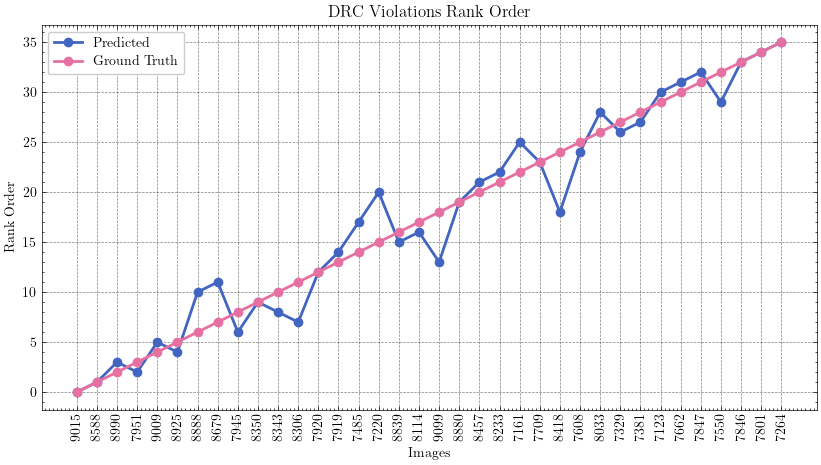

In [63]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.5861636240184043), pvalue=np.float64(6.974583440810761e-84)),
 'SRCC': SignificanceResult(statistic=np.float64(0.3080620534422566), pvalue=np.float64(3.580982211478028e-21)),
 'KRCC': SignificanceResult(statistic=np.float64(0.20988665065822534), pvalue=np.float64(4.9256785077609464e-21))}

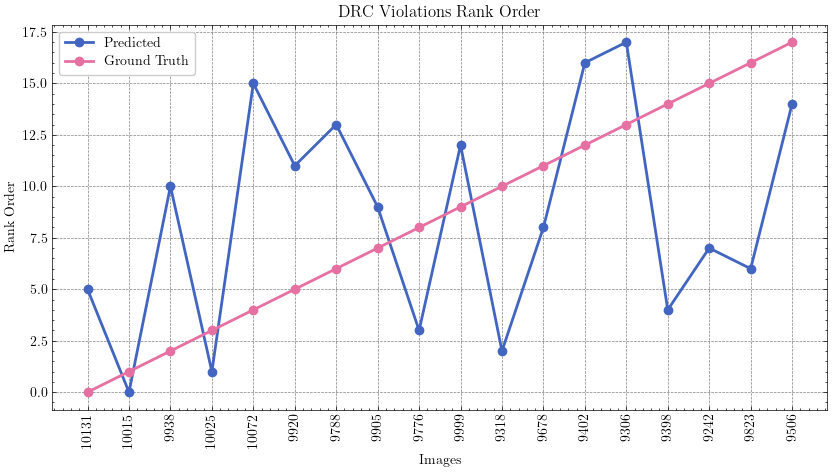

In [64]:
evaluate_design(test_df_b)

Text(0, 0.5, 'Feature')

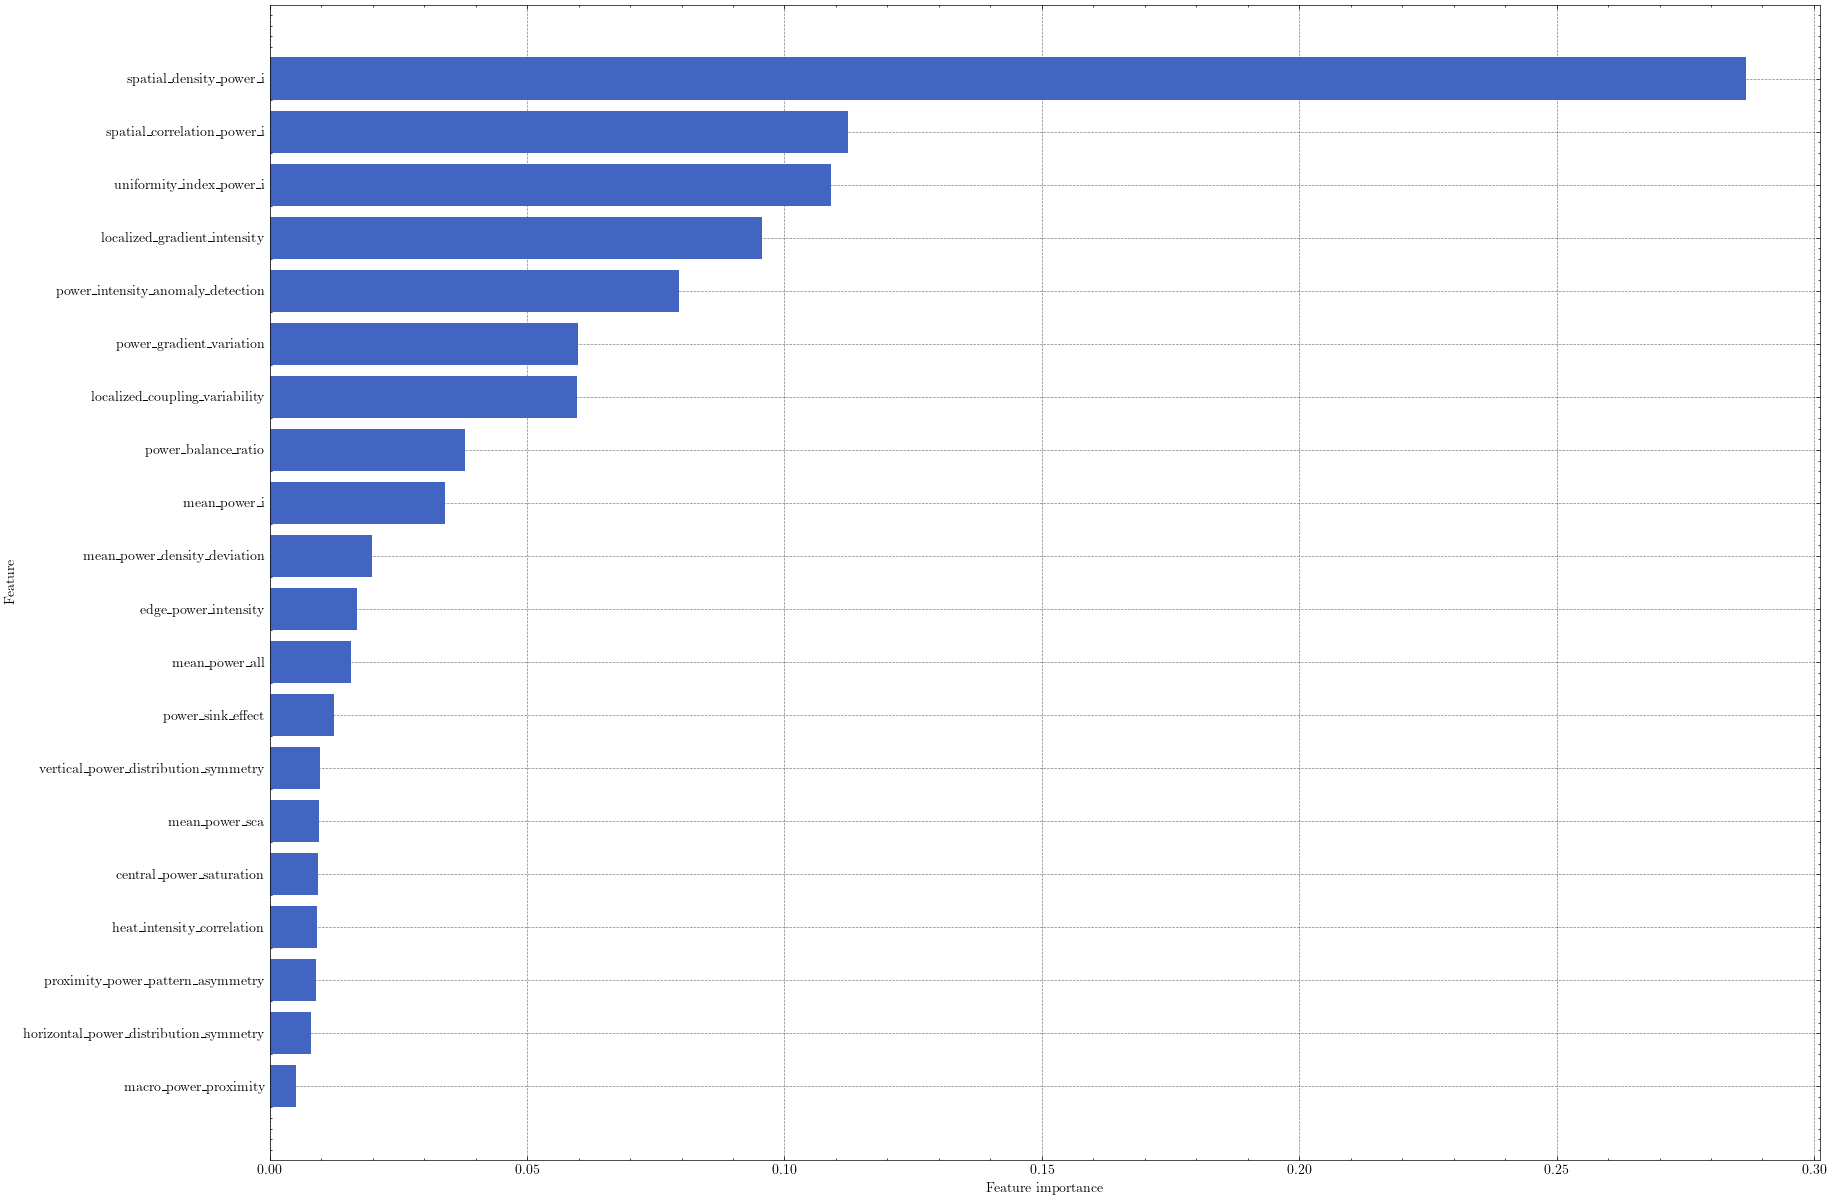

In [65]:
feature_importance = regressor.feature_importances_ 
sorted_idx = np.argsort(feature_importance) # Sort index on feature importance
fig = plt.figure(figsize=(20, 15)) # Set plot size (denoted in inches)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x.columns)[sorted_idx])

plt.xlabel("Feature importance") # Add x axis
plt.ylabel("Feature") # Add y axis

In [66]:
feat_pool

{'horizontal_power_distribution_symmetry': 'symmetry level of power distribution along the horizontal axis across the layout',
 'mean_power_sca': 'the average of the toggle rate scaled power in the layout',
 'heat_intensity_correlation': 'correlation between power density and expected thermal hotspots',
 'central_power_saturation': 'the saturation level of power distribution concentrated at the central region of the layout',
 'vertical_power_distribution_symmetry': 'symmetry level of power distribution along the vertical axis across the layout',
 'proximity_power_pattern_asymmetry': 'the asymmetry in power distribution patterns between neighboring regions indicating potential IR Drop irregularities',
 'macro_power_proximity': 'the influence of power distribution in proximity to macros',
 'mean_power_density_deviation': 'the average deviation of power density from the mean across the layout regions',
 'edge_power_intensity': 'the intensity of power distribution along the edges of the la

In [67]:
feat_func_list

[<function __main__.horizontal_power_distribution_symmetry(images)>,
 <function __main__.mean_power_sca(images)>,
 <function __main__.heat_intensity_correlation(images)>,
 <function __main__.central_power_saturation(images)>,
 <function __main__.vertical_power_distribution_symmetry(images)>,
 <function __main__.proximity_power_pattern_asymmetry(images)>,
 <function __main__.macro_power_proximity(images)>,
 <function __main__.mean_power_density_deviation(images)>,
 <function __main__.edge_power_intensity(images)>,
 <function __main__.power_sink_effect(images)>,
 <function __main__.mean_power_all(images)>,
 <function __main__.mean_power_i(images)>,
 <function __main__.power_balance_ratio(images)>,
 <function __main__.power_gradient_variation(images)>,
 <function __main__.localized_coupling_variability(images)>,
 <function __main__.power_intensity_anomaly_detection(images)>,
 <function __main__.localized_gradient_intensity(images)>,
 <function __main__.spatial_correlation_power_i(images)>